# 전처리

In [1]:
## 기본 데이터 핸들링 및 수학 연산
import pandas as pd
import numpy as np
from scipy import stats

## 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

## 통계 분석 및 검정
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, spearmanr
from statsmodels.stats.multitest import multipletests

## 데이터 전처리 및 파이프라인 구성
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.utils import resample

## 머신러닝 모델링
### 전통적 회귀/분류 모델
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans

### 고성능 트리 기반 모델 (LightGBM)
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

### 모델 보정 (Calibration)
from sklearn.isotonic import IsotonicRegression

### 성능 평가 지표 (Metrics)
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    recall_score, roc_auc_score, average_precision_score, 
    brier_score_loss, silhouette_score
)
from sklearn.calibration import calibration_curve

## 모델 해석 및 설명
import shap

In [2]:
# 파일 불러오기

df_transactions = pd.read_csv("transactions_train.csv")
df_articles = pd.read_csv("articles.csv")
df_customers = pd.read_csv("customers.csv")

In [3]:
# transactions_train 전처리
df_transactions['t_dat'] = pd.to_datetime(df_transactions['t_dat'])

# articles 전처리
df_articles = df_articles[['article_id', 'product_type_name']]

## 카테고리 매핑
def map_product_group(x):
    if pd.isna(x):
        return 'OTHER'
    x = x.lower()

    if any(k in x for k in ['sweater','blouse','t-shirt','shirt','top','hoodie',
                            'cardigan','polo','bodysuit','waistcoat']):
        return 'TOPS'

    elif any(k in x for k in ['trouser','skirt','short','legging']):
        return 'BOTTOMS'

    elif any(k in x for k in ['dress','jumpsuit','playsuit','dungaree','garment set']):
        return 'DRESSES'

    elif any(k in x for k in ['jacket','coat','blazer','outer','overall']):
        return 'OUTERWEAR'

    elif any(k in x for k in ['underwear','bra','pyjama','night','robe','sleep','long john','underwear top','underdress']):
        return 'UNDERWEAR_SLEEP'

    elif any(k in x for k in ['swim','bikini','sarong']):
        return 'SPORTS_SWIM'

    elif any(k in x for k in ['boot','shoe','sneaker','sandal','slipper',
                              'heel','flip','moccasin','ballerina','wedge','pump','walker']):
        return 'SHOES'

    elif any(k in x for k in ['bag','belt','hat','cap','scarf','glove','wallet',
                              'hair','bracelet','necklace','ring','earring',
                              'watch','sunglass','umbrella','keychain',
                              'mobile','earphone','eyeglass','underwear Tight','beanie','accessories','tie','alice','nipple','backpack']):
        return 'ACCESSORY'

    else:
        return 'OTHER'


df_articles['product_group'] = df_articles['product_type_name'].apply(map_product_group)
df_articles= df_articles.drop(columns=['product_type_name'])

# customer 전처리
df_customers['club_member_status'] = df_customers['club_member_status'].fillna('NON_MEMBER')
df_customers['age'] = df_customers['age'].astype(float)

## 연령대 파생변수 생성
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 120]
labels = ['10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대+']
df_customers['age_group'] = pd.cut(
    df_customers['age'],
    bins=bins,
    labels=labels,
    right=False)

df_customers= df_customers[['customer_id', 'club_member_status', 'fashion_news_frequency', 'age_group']]

In [4]:
# transactions + articles 병합
df_merged= df_transactions.merge(df_articles ,on='article_id',how='left')

# df_merged + customers 병합
df_merged = df_merged.merge(df_customers, on='customer_id',how='left')

In [5]:
# df_merged CSV화
# df_merged.to_csv('df_merged.csv',index=False)

# 스냅샷


In [6]:
# T 이전 데이터 분리 (훈련 데이터)
T = pd.to_datetime("2020-06-22")
df_past = df_merged[df_merged['t_dat'] < T].copy()
last_purchase = (
    df_past
    .groupby("customer_id")["t_dat"]
    .max()
    .reset_index(name="last_purchase_date"))
## T로부터 최근 거래
last_purchase["recency"] = (T - last_purchase["last_purchase_date"]).dt.days


# T로부터 6개월 전까지 데이터
six_months_ago = T - pd.DateOffset(months=6)
df_6m = df_past[df_past["t_dat"] >= six_months_ago].copy()


# T로부터 6개월 전까지 집계 및 파생변수 생성
derived_variables = (
    df_6m
    .groupby("customer_id")
    .agg(
        ## 빈도
        frequency_6m=("t_dat", "count"),
        ## 금액
        monetary_6m=("price", "sum"),
        ## 다양성
        diversity_6m=("product_group", "nunique"),).reset_index())


# 스냅샷 생성 (RFMD 통합본)
df_snapshot = (
    last_purchase[["customer_id", "last_purchase_date", "recency"]]
    .merge(derived_variables[["customer_id", "frequency_6m", "monetary_6m", "diversity_6m"]],
        on="customer_id",
        how="left"))


# 최근 6개월 구매 없는 고객 0처리 (Recency > 180일 = 0)
base_fill = ["frequency_6m", "monetary_6m", "diversity_6m"]
df_snapshot[base_fill] = df_snapshot[base_fill].fillna(0)


# 스냅샷 파생변수 생성 (+1은 분모가 0되는 것 방지)
## 고객당 평균 구매 단가
df_snapshot["aov_6m"] = df_snapshot["monetary_6m"] / (df_snapshot["frequency_6m"] + 1)
## 카테고리당 구매 빈도
df_snapshot["freq_per_div"] = df_snapshot["frequency_6m"] / (df_snapshot["diversity_6m"] + 1)
## 시간 대비 구매 빈도 (최근 활동 밀집도)
df_snapshot["freq_per_recency"] = df_snapshot["frequency_6m"] / (df_snapshot["recency"] + 1)
## 구매 횟수 대비 상품 다양성
df_snapshot["focus_6m"] = df_snapshot["diversity_6m"] / (df_snapshot["frequency_6m"] + 1)
## 시간 대비 지출 강도
df_snapshot["intensity_6m"] = df_snapshot["monetary_6m"] / (df_snapshot["recency"] + 1)


# 군집

In [7]:
# 로그 변환
log_cols = [
    "recency",
    "frequency_6m",
    "monetary_6m",
    "diversity_6m"]

for c in log_cols:
    df_snapshot[f"{c}_log"] = np.log1p(df_snapshot[c])


# 모델에 사용할 피쳐
cluster_features = [
    "recency_log",
    "frequency_6m_log",
    "monetary_6m_log",
    "diversity_6m_log"]

X_features = df_snapshot[cluster_features]


# x피쳐 스케일링 (이상치 영향 최소화하기 위해 로버스터 사용)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_features)

In [8]:
# 최적 K찾기

## 데이터 샘플링
if X_scaled.shape[0] > 70000:
    X_sample = resample(
        X_scaled,
        n_samples=70000,
        random_state=42,
        replace=False)
else:
    X_sample = X_scaled.copy()

## K범위 지정
K_range = range(2, 11)
inertia = []
sil_scores = []

## K찾기 진행
for k in K_range:
    ### init은 서로 다른 시작점에서 20번 시도하여 제일 좋은 곳 선택하라 (모델 안정성 향상)
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_sample)
    ### inertia는 성능지표로 작을수록 군집 간격 좁음
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_sample, labels))

## 결과 데이터프레임화
elbow_df = pd.DataFrame({
    'k': list(K_range),
    'inertia': inertia,
    'silhouette': sil_scores})

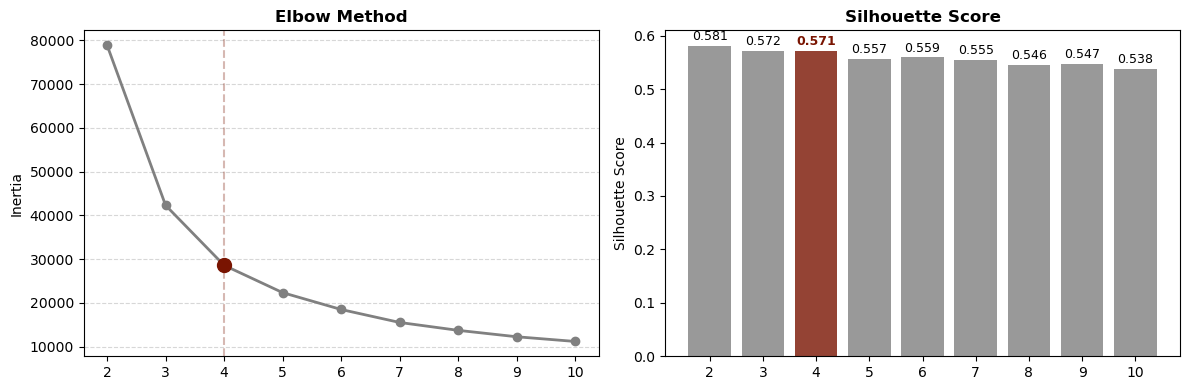

In [9]:
# 엘보우 그래프 및 실루엣 스코어 시각화

highlight_color = '#791401'  
default_color = '#808080'   

plt.figure(figsize=(12, 4))

## 엘보우 그래프
plt.subplot(1, 2, 1)
plt.plot(elbow_df['k'], elbow_df['inertia'], marker='o', color=default_color, linewidth=2, label='Inertia')

### K=4 강조
k5_inertia = elbow_df.loc[elbow_df['k'] == 4, 'inertia'].values[0]
plt.plot(4, k5_inertia, marker='o', markersize=10, color=highlight_color, linestyle='None')
plt.axvline(x=4, color=highlight_color, linestyle='--', alpha=0.3)

plt.xticks(elbow_df['k'])
plt.ylabel('Inertia')
plt.title('Elbow Method', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

## 실루엣 스코어
plt.subplot(1, 2, 2)

### K=4 강조
colors = [highlight_color if k == 4 else default_color for k in elbow_df['k']]
bars = plt.bar(elbow_df['k'], elbow_df['silhouette'], color=colors, alpha=0.8)

plt.xticks(elbow_df['k'])
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score', fontsize=12, fontweight='bold')

### 막대 상단에 수치 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9,
             fontweight='bold' if elbow_df['k'].iloc[i] == 4 else 'normal',
             color=highlight_color if elbow_df['k'].iloc[i] == 4 else 'black')

plt.tight_layout()
plt.show()

In [10]:
# 군집 설정

## 군집 수 지정
K = 4

## K-means 모델 생성
kmeans = KMeans(
    n_clusters=K,
    random_state=42,
    n_init=20)

## 클러스터 결과 컬럼화
df_snapshot['cluster_id'] = kmeans.fit_predict(X_scaled)

In [11]:
#군집 결과 요약
cluster_summary = (
    df_snapshot
    .groupby('cluster_id')
    .agg(
        customer_cnt=('customer_id', 'count'),
        frequency_6m=('frequency_6m', 'mean'),
        diversity_6m=('diversity_6m', 'mean'),
        recency=('recency','mean'),
        monetary=('monetary_6m','mean')).round(2))

cluster_summary

,customer_cnt,frequency_6m,diversity_6m,recency,monetary
cluster_id,,,,,
0,198017,15.59,4.24,37.14,0.42
1,598569,0.06,0.05,380.25,0.00
2,50058,44.83,5.92,23.33,1.37
3,440108,4.32,2.13,71.74,0.11


In [12]:
# 군집화 파일 생성
# df_snapshot.to_csv('cluster_k4.csv',index=False)

# 분류

In [13]:
# 파일 불러오기
df_cluster=pd.read_csv("cluster_k4.csv")

In [14]:
# 타입 변환
df_merged['t_dat'] = pd.to_datetime(df_merged['t_dat'])

In [15]:
# 이탈 라벨링

## 이탈 기준 : T 이후 90일 무구매
N_DAYS = 90 
## T + 90일 데이터 분리 (테스트 데이터)
df_future = df_merged[(df_merged['t_dat'] >= T) & (df_merged['t_dat'] < T + pd.Timedelta(days=N_DAYS))]

## 미래 구매가 있는 고객 → churn = 0
future_flag = (
    df_future[['customer_id']]
    .drop_duplicates()
    .assign(churn=0)
)

## 스냅샷 (과거 데이터) + 이탈 라벨 결합 → 과거와 미래 결합 시 있는 것은 0 붙고 없는 것은 missing value
df_cluster_churn = (
    df_cluster
    .merge(future_flag, on='customer_id', how='left')
)

## 미래 구매가 없는 고객 → churn = 1
df_cluster_churn['churn'] = (
    df_cluster_churn['churn']
    .fillna(1)
    .astype(int)
)

In [16]:
# 로그 변환 (스냅샷에서 만든 파생변수) - 누수 방지
df_cluster_churn["intensity_6m_log"] = np.log1p(df_cluster_churn["intensity_6m"])
df_cluster_churn["aov_6m_log"] = np.log1p(df_cluster_churn["aov_6m"])
df_cluster_churn['focus_6m_log']           = np.log1p(df_cluster_churn['focus_6m'])
df_cluster_churn['freq_per_div_log']       = np.log1p(df_cluster_churn['freq_per_div'])
df_cluster_churn['freq_per_recency_log']   = np.log1p(df_cluster_churn['freq_per_recency'])

## 통계 분석

In [17]:
# 분석 피처 설정
target_col = "churn"
alpha = 0.05
features = [
    "recency",
    "frequency_6m",
    "monetary_6m",
    "diversity_6m",
    "focus_6m",
    "intensity_6m",
    "aov_6m",
    "freq_per_div",
    "freq_per_recency",
]

In [18]:
# 분석을 위한 전처리 및 검정 도구

## inf값 제거
def clean_series(s):
    s = pd.to_numeric(s, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    return s

## 정규성 검정
def shapiro_normal(x, alpha=0.05, max_n=5000):
    n = len(x)
    if n < 30:
        return False
    if n > max_n:
        x = x.sample(max_n, random_state=42)
    return shapiro(x).pvalue > alpha

## 비모수 검정 (g0 > g1 이면 +)
def rank_biserial_from_u(U, n0, n1): 
    return (2 * U) / (n0 * n1) - 1

## 이탈 0, 1 외 다른 것이 있어도 정수형 유지
df_cluster_churn[target_col] = pd.to_numeric(df_cluster_churn[target_col], errors="coerce").astype("Int64")

In [19]:
# 검정 루프 (자동 탐색)
rows = []

## 유지, 이탈고객 분리
for f in features:
    g0 = clean_series(df_cluster_churn.loc[df_cluster_churn[target_col] == 0, f])
    g1 = clean_series(df_cluster_churn.loc[df_cluster_churn[target_col] == 1, f])
    n0, n1 = len(g0), len(g1)
    
### 둘다 데이터가 없다면 rows에 NaN 기록 후 검정 패스
    if n0 == 0 or n1 == 0:
        rows.append({
            "feature": f,
            "p_value": np.nan,
            "effect_size": np.nan,
            "effect_type": np.nan,
        })
        continue

    ### 정규성 검정
    norm0 = shapiro_normal(g0, alpha)
    norm1 = shapiro_normal(g1, alpha)

    ### 등분산성 검정 (정규성 만족 시)
    equal_var = False
    if norm0 and norm1:
        p_lev = levene(g0, g1, center="median").pvalue
        equal_var = (p_lev > alpha)

    ### 어떤 통계 도구 쓸지 결정
    if norm0 and norm1:
        #### 모수 검정 (정규성 만족 시)
        t = ttest_ind(g0, g1, equal_var=equal_var)
        p = float(t.pvalue)
        eff = g0.mean() - g1.mean()
        eff_type = "mean_diff(0-1)"
    else:
        #### 비모수 검정 (정규성 꺠짐 시)
        m = mannwhitneyu(g0, g1, alternative="two-sided")
        U, p = float(m.statistic), float(m.pvalue)
        eff = rank_biserial_from_u(U, n0, n1)
        eff_type = "rank-biserial r"
    
    ### 결과 저장
    rows.append({
        "feature": f,
        "p_value": p,
        "effect_size": eff,
        "effect_type": eff_type,
    })
    
result_df = pd.DataFrame(rows)

In [20]:
result_df

,feature,p_value,effect_size,effect_type
0,recency,0.0,-0.561682,rank-biserial r
1,frequency_6m,0.0,0.552183,rank-biserial r
2,monetary_6m,0.0,0.540032,rank-biserial r
3,diversity_6m,0.0,0.550869,rank-biserial r
4,focus_6m,0.0,0.347614,rank-biserial r
5,intensity_6m,0.0,0.554883,rank-biserial r
6,aov_6m,0.0,0.456153,rank-biserial r
7,freq_per_div,0.0,0.530029,rank-biserial r
8,freq_per_recency,0.0,0.559548,rank-biserial r


In [21]:
# 다중비교로 분석 신뢰도 향상 (1종 오류 제어)

## p_value없는 것 제외
mask = result_df["p_value"].notna()

## p_value 강하게 분석
rej, qvals, _, _ = multipletests(
    result_df.loc[mask, "p_value"].values,
    alpha=alpha,
    method="fdr_bh"
)

### 결과 저장
result_df.loc[mask, "q_fdr_bh"] = qvals
result_df.loc[mask, "significant_fdr"] = rej

In [22]:
# 최종 결과 (유의미 하면서 영향력 큰 순으로 정렬)

final_df = (
    result_df[["feature", "q_fdr_bh", "effect_size", "effect_type"]]
    ## 차이의 강도만 보기위해 절댓값
    .assign(abs_effect=lambda x: x["effect_size"].abs())
    .sort_values(["q_fdr_bh", "abs_effect"], ascending=[True, False])
    .reset_index(drop=True)
)

## 보류 로지스틱 다음단계

In [23]:
# Isotonic 모델이 학습한 확률 변환 곡선 함수화 (번역이 어떻게 되었는가)

## iso : Isotonic 모델 (번역기)
def pretty_isotonic_mapping_plot(iso, title="Isotonic mapping"):
    ## 변환 곡선을 더 자세히 보기 위해 그리드 쪼개는 작업
    grid = np.linspace(0, 1, 501)
    ## iso가 기존 확률에서 교정된 확률로 변환
    mapped = iso.transform(grid)

    plt.figure(figsize=(6.6, 6.6), dpi=150)
    ## 매핑된 곡선
    plt.plot(grid, mapped, linewidth=2.2, label="Isotonic mapping")
    plt.plot([0,1],[0,1], "--", linewidth=1.6, label="Identity")

    ## 차트 스케일링 (가독성 확보)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("Base predicted probability")
    plt.ylabel("Calibrated probability")
    plt.title(title, pad=12)

    ## 디자인
    plt.grid(True, linewidth=0.8, alpha=0.35)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.legend(frameon=True, fancybox=True)
    plt.tight_layout()
    plt.show()


In [24]:
# Calibration 그래프 함수화 (모델이 내뱉는 확률값의 번역 전과 후의 정확성 확인)

## p_base : 보정 전 예측 확률, p_iso : Isotonic으로 보정된 예측 확률
def pretty_calibration_plot(y_true, p_base, p_iso, title, n_bins=12):
    ## 동일하게 샘플 수 배분 (신뢰도 확보)
    pt_b, pp_b = calibration_curve(y_true, p_base, n_bins=n_bins, strategy="quantile")
    pt_i, pp_i = calibration_curve(y_true, p_iso,  n_bins=n_bins, strategy="quantile")

    plt.figure(figsize=(6.6, 6.6), dpi=150)
    plt.plot(pp_b, pt_b, marker="o", linewidth=2.2, markersize=6, label="Base (OOF)")
    plt.plot(pp_i, pt_i, marker="o", linewidth=2.2, markersize=6, label="Isotonic 1-shot (OOF)")
    plt.plot([0,1],[0,1], "--", linewidth=1.6, label="Perfect")

    ## 차트 스케일링 (가독성 확보)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("Predicted probability", labelpad=10)
    plt.ylabel("Observed rate", labelpad=10)
    plt.title(title, pad=12)

    ## 디자인
    plt.grid(True, linewidth=0.8, alpha=0.35)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.legend(frameon=True, fancybox=True)
    plt.tight_layout()
    plt.show()


## ------------------

## 로지스틱

In [25]:
# 로지스틱 위한 전처리

num_features_logit = [
    "recency_log","frequency_6m_log","monetary_6m_log","diversity_6m_log",
    "focus_6m_log","aov_6m_log","freq_per_div_log","freq_per_recency_log",'intensity_6m_log'
]

cat_features = ["cluster_id"]

## 변수 분리
X = df_cluster_churn[num_features_logit + cat_features].copy()
Y = df_cluster_churn["churn"].astype(int).copy()
## 피처 존재 여부 확인
missing = [c for c in (num_features_logit + cat_features) if c not in X.columns]
assert len(missing) == 0, f"X에 없는 컬럼: {missing}"

print("N:", len(X), "| churn rate:", float(Y.mean()))

## 수치형/범주형 데이터를 분리하여 누수 없이 통합 처리 (파이프라인 통해 빈칸, 규격을 맞춤)
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ]), num_features_logit),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ],
    remainder="drop"
)

N: 1286752 | churn rate: 0.6467998495436572


In [26]:
# 로지스틱 모델 설정

base_logit = LogisticRegression(
    max_iter=2000,
    ## 불균형 문제로 가중치 부여
    class_weight="balanced",
    n_jobs=-1,
    ## 최적의 가중치 찾는 최적화 알고리즘
    solver="lbfgs"
)



In [27]:
# 이탈 확률 산출

## StratifiedKFold으로 churn 비율을 유지하며 분할
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
## 예측 값 저장소 생성
oof_p_base = np.full(len(X), np.nan, dtype=float)

## 확률 산출 
for fold, (tr_idx, va_idx) in enumerate(skf.split(X, Y), 1):
    ### 훈련, 확인 데이터 분리
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    Y_tr, Y_va = Y.iloc[tr_idx], Y.iloc[va_idx]

    ### clone을 통해 이전 폴드의 학습 기억 리셋 (누수 방지)
    prep = clone(preprocess)
    ### fit_transform사용하면 X_tr로만 학습
    Xtr = prep.fit_transform(X_tr, Y_tr)
    ### 위에서 학습한 기준을 확인 데이터에 적용 (스케일링)
    Xva = prep.transform(X_va)

    ### 이전 폴드의 학습 기억 리셋
    m = clone(base_logit)
    ### 전처리된 데이터로 학습 후 기준 세우기
    m.fit(Xtr, Y_tr)
    ### 위 기준을 기반으로 proba를 통한 확률 예측 후 적재
    oof_p_base[va_idx] = m.predict_proba(Xva)[:, 1]

    ### 확인 데이터의 이탈률을 보며 폴드마다 이탈률 분배가 잘 되었는지 확인
    print(f"fold {fold} done | churn rate={float(Y_va.mean()):.4f}")

## 만약 NaN이 있다면 데이터를 빼먹은 것
assert not np.isnan(oof_p_base).any(), "OOF base에 NaN이 남아있음"



fold 1 done | churn rate=0.6468
fold 2 done | churn rate=0.6468
fold 3 done | churn rate=0.6468
fold 4 done | churn rate=0.6468
fold 5 done | churn rate=0.6468


In [28]:
# Isotonic으로 모델의 상대적 점수를 실제 이탈 확률로 교정 (번역기)

## 안전성 확보 (확률이 0이나 1이면 계산 시 inf값이 나올 수 있음)
eps = 1e-6
### 미세한 차이를 둬 방지
oof_p_base_clip = np.clip(oof_p_base, eps, 1 - eps)

## 보정 모델 생성
### IsotonicRegression : 점수가 높으면 확률도 높아라, clip : 범위를 벗어난 점수가 나와도 최소/최대 확률 값으로 고정
iso_logit = IsotonicRegression(out_of_bounds="clip")
### 보정 로직 학습 (예측 점수와 실제 정답지와 관계 학습)
iso_logit.fit(oof_p_base_clip, Y.values)
### 최종 보정 확률 산출 (검증된 확률로 변환)
oof_p_iso = iso_logit.transform(oof_p_base_clip)
### 데이터 누락 확인
assert not np.isnan(oof_p_iso).any()

In [29]:
# 성과 지표

## 모델 생성
def report(name, yy, pp):
    return {
        "model": name,
        ### 확률 정확도 (0에 가까울수록 좋음)
        "brier": brier_score_loss(yy, pp),
        ### 이탈자와 유지자를 잘 구분했는가 (1에 가까울수록 좋음)
        "roc_auc": roc_auc_score(yy, pp),
        ### 적은 데이터인 이탈자를 잘 찾았는가
        "pr_auc": average_precision_score(yy, pp),
    }

## 모델 성과 저장
res_logit = pd.DataFrame([
    report("OOF Base (Logit)", Y, oof_p_base),
    report("OOF Iso 1-shot (Logit)", Y, oof_p_iso),
]).sort_values("brier")

display(res_logit)

,model,brier,roc_auc,pr_auc
1,OOF Iso 1-shot (Logit),0.168129,0.801869,0.869156
0,OOF Base (Logit),0.182129,0.801762,0.870609


## LGBM

In [30]:
# LGBM 위한 전처리

df_cluster_churn_lgbm = df_cluster_churn.copy()

num_features_lgbm = [
    "recency_log","frequency_6m_log","monetary_6m_log","diversity_6m_log",
    "focus_6m_log","aov_6m_log","freq_per_div_log","freq_per_recency_log","intensity_6m_log"
]
    
## 변수 분리
X = df_cluster_churn_lgbm[num_features_lgbm + cat_features].copy()
y = df_cluster_churn_lgbm["churn"].astype(int).copy()

## 피처 존재 여부 확인
missing = [c for c in (num_features_lgbm + cat_features) if c not in X.columns]
assert len(missing) == 0, f"X에 없는 컬럼: {missing}"

## 전체 데이터 규모 및 모델 성능 평가의 기준점 확인
print("N:", len(X), "| churn rate:", float(y.mean()))

## 수치형/범주형 데이터를 분리하여 누수 없이 통합 처리 (파이프라인을 통해 결측치 보완 및 데이터 형식 최적화)
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))]), num_features_lgbm),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ],
    remainder="drop"
)

N: 1286752 | churn rate: 0.6467998495436572


In [31]:
# LGBM 모델 설정

base_lgbm = LGBMClassifier(
    ## Early Stopping을 사용하므로 큰 값 설정 (최적의 반복 횟수 탐색용)
    n_estimators=5000,
    ## 학습률 속도 조절 (모델의 수렴 안정성 확보)
    learning_rate=0.05,
    ## 트리 복잡도 제어 (과적합 방지)
    num_leaves=31,
    ## 데이터의 80%만 무작위 사용 (배깅효과 및 과적합 방지)
    subsample=0.8,
    ## 피쳐의 80%만 사용 (변수 간 의존성 제거)
    colsample_bytree=0.8,
    ## 불균형으로 가중치 부여
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    force_row_wise=True
)



In [32]:
# 이탈 확률 산출

## StratifiedKFold으로 churn 비율을 유지하며 분할
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
## 예측 값 저장소 생성
oof_p_base = np.full(len(X), np.nan, dtype=float)
## 최적의 성능 반복 횟수 저장소
best_iters = []

## 확률 산출 
for fold, (tr_idx, va_idx) in enumerate(skf.split(X, Y), 1):
    ### 훈련, 확인 데이터 분리
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    Y_tr, Y_va = Y.iloc[tr_idx], Y.iloc[va_idx]

    ### clone을 통해 이전 폴드의 학습 기억 리셋 (누수 방지)
    prep = clone(preprocess)
    ### fit_transform사용하면 X_tr로만 학습
    Xtr = prep.fit_transform(X_tr, Y_tr)
    ### 위에서 학습한 기준을 확인 데이터에 적용 (스케일링)
    Xva = prep.transform(X_va)

    ### 이전 폴드의 학습 기억 리셋
    clf = clone(base_lgbm)
    clf.fit(
        Xtr, Y_tr,
        ### 확인 데이터 모니터링 (과적합 방지)
        eval_set=[(Xva, Y_va)],
        eval_metric="binary_logloss",
        ### 성능 개선 없으면 조기 중단
        callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
    )

    ### 위 기준을 기반으로 proba를 통한 확률 예측 후 적재
    oof_p_base[va_idx] = clf.predict_proba(Xva)[:, 1]
    ### 현재 폴드에서 성능이 좋았던 반복 횟수 기록
    best_iters.append(clf.best_iteration_)
    ### 각 폴드별 이탈률 분배 상태 및 학습 진행 상황 출력
    print(f"fold {fold} done | churn rate={float(Y_va.mean()):.4f} | best_iter={clf.best_iteration_}")

## 만약 NaN이 있다면 데이터를 빼먹은 것
assert not np.isnan(oof_p_base).any(), "OOF base에 NaN이 남아있음 (인덱스/로직 확인 필요)"
## 전체 폴드의 최적 반복 횟수 중앙값을 최종 모델 파라미터로 산출
best_iter_final = int(np.median(best_iters))
print("best_iter_final (median):", best_iter_final)

[LightGBM] [Info] Number of positive: 665817, number of negative: 363584
[LightGBM] [Info] Total Bins 1868
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


fold 1 done | churn rate=0.6468 | best_iter=789
[LightGBM] [Info] Number of positive: 665816, number of negative: 363585
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


fold 2 done | churn rate=0.6468 | best_iter=501
[LightGBM] [Info] Number of positive: 665817, number of negative: 363585
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


fold 3 done | churn rate=0.6468 | best_iter=536
[LightGBM] [Info] Number of positive: 665817, number of negative: 363585
[LightGBM] [Info] Total Bins 1870
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


fold 4 done | churn rate=0.6468 | best_iter=410
[LightGBM] [Info] Number of positive: 665817, number of negative: 363585
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


fold 5 done | churn rate=0.6468 | best_iter=595
best_iter_final (median): 536


In [33]:
# Isotonic으로 모델의 상대적 점수를 실제 이탈 확률로 교정 (번역기)

## 안전성 확보 (확률이 0이나 1이면 계산 시 inf값이 나올 수 있음)
eps = 1e-6
### 미세한 차이를 둬 방지
oof_p_base_clip = np.clip(oof_p_base, eps, 1 - eps)

## 보정 모델 생성
### IsotonicRegression : 점수가 높으면 확률도 높아라, clip : 범위를 벗어난 점수가 나와도 최소/최대 확률 값으로 고정
iso_lgbm = IsotonicRegression(out_of_bounds="clip")
### 보정 로직 학습 (예측 점수와 실제 정답지와 관계 학습)
iso_lgbm.fit(oof_p_base_clip, Y.values)
### 최종 보정 확률 산출 (검증된 확률로 변환)
oof_p_iso = iso_lgbm.transform(oof_p_base_clip)
### 데이터 누락 확인
assert not np.isnan(oof_p_iso).any()

In [34]:
# 성과 지표

## 모델 생성
def report(name, yy, pp):
    return {
        "model": name,
        ### 확률 정확도 (0에 가까울수록 좋음)
        "brier": brier_score_loss(yy, pp),
        ### 이탈자와 유지자를 잘 구분했는가 (1에 가까울수록 좋음)
        "roc_auc": roc_auc_score(yy, pp),
        ### 적은 데이터인 이탈자를 잘 찾았는가
        "pr_auc": average_precision_score(yy, pp),
    }

## 모델 성과 저장
res_logit = pd.DataFrame([
    report("OOF Base (Logit)", Y, oof_p_base),
    report("OOF Iso 1-shot (Logit)", Y, oof_p_iso),
]).sort_values("brier")

display(res_logit)

,model,brier,roc_auc,pr_auc
1,OOF Iso 1-shot (Logit),0.166912,0.804739,0.871047
0,OOF Base (Logit),0.179568,0.804663,0.872176


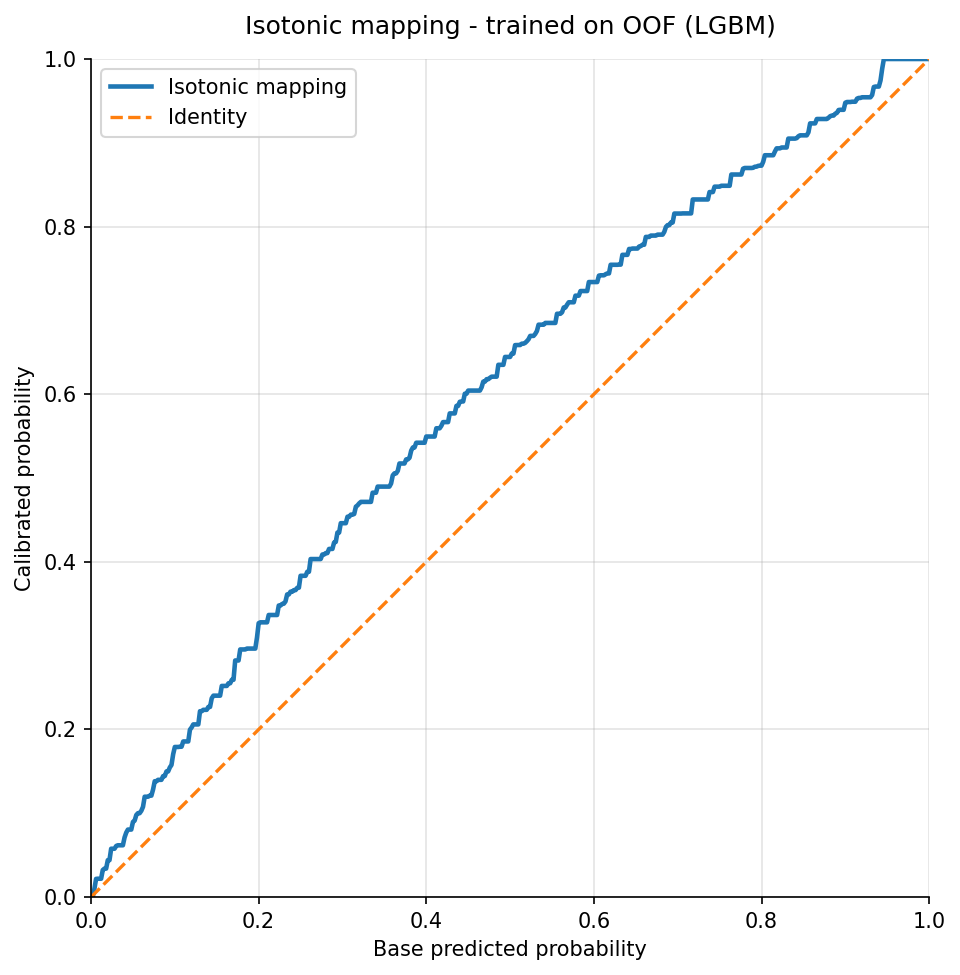

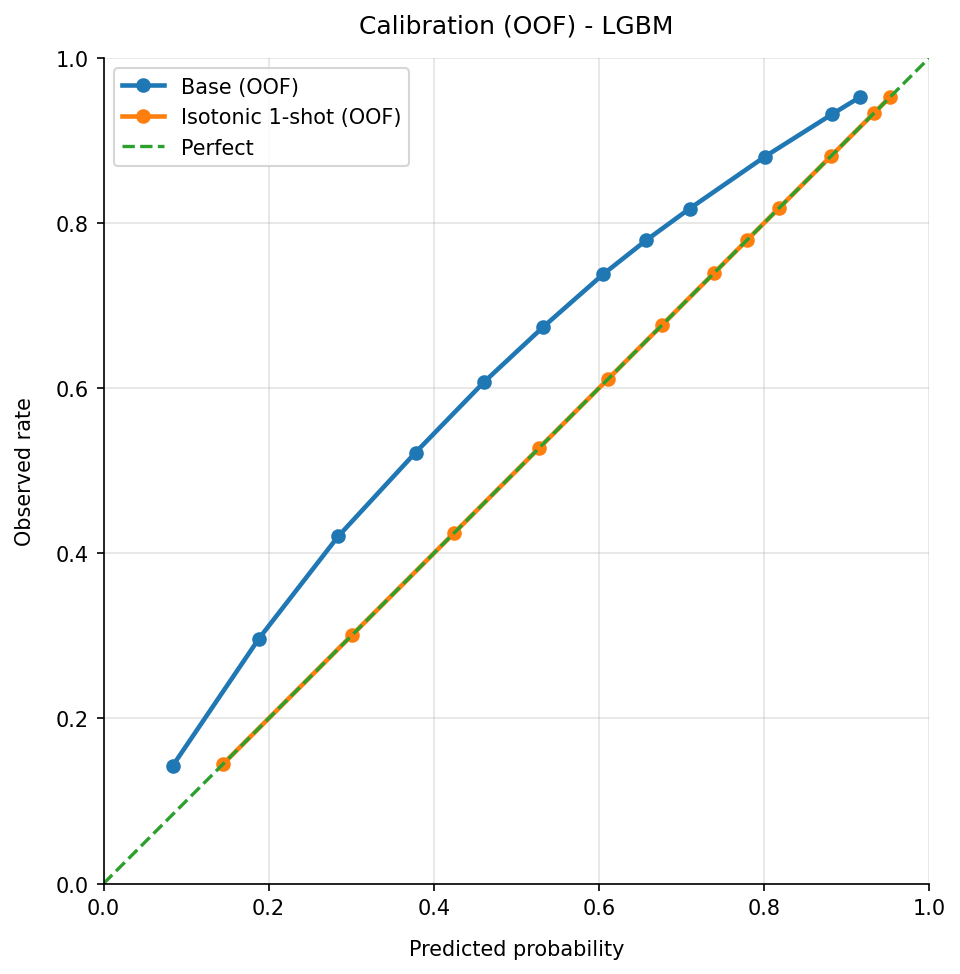

In [35]:
# LGBM 성능 시각화 (로지스틱보다 성능이 좋음)

## Isotonic 모델이 학습한 확률 변환 곡선 함수화 (번역이 어떻게 되었는가)
pretty_isotonic_mapping_plot(iso_lgbm, title="Isotonic mapping - trained on OOF (LGBM)")
## Calibration 그래프 함수화 (모델이 내뱉는 확률값의 번역 전과 후의 정확성 확인)
pretty_calibration_plot(Y, oof_p_base, oof_p_iso, title="Calibration (OOF) - LGBM")

In [36]:
# 결과 저장

df_cluster_churn_lgbm["churn_proba_lgbm_isotonic"] = oof_p_iso

## SHAP

[LightGBM] [Info] Number of positive: 832271, number of negative: 454481
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 1286752, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


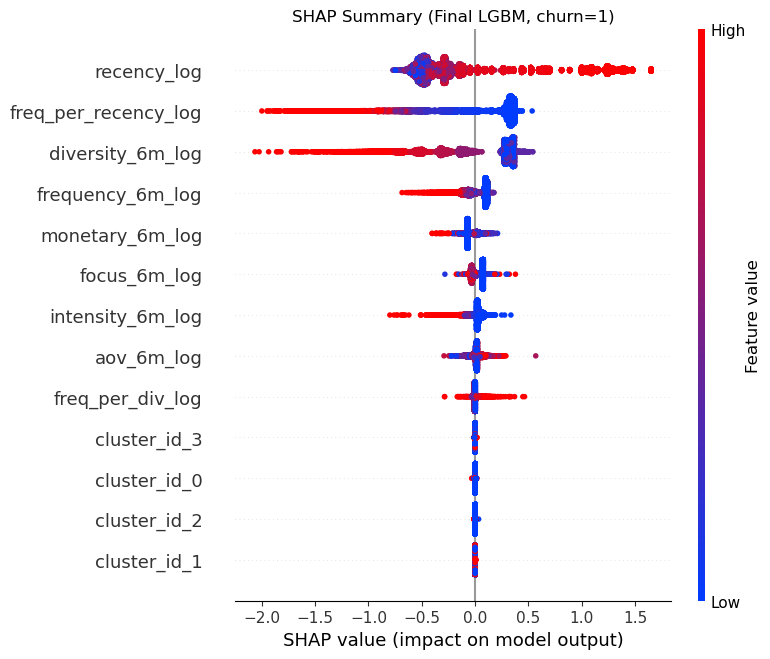

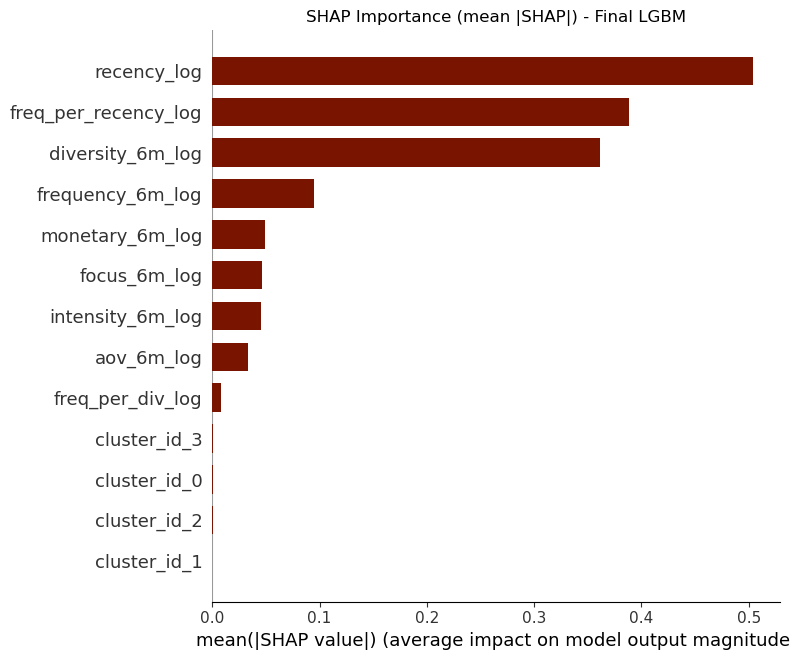

In [37]:
# SHAP 해석

## 전처리
### 전체 데이터셋을 기준으로 새로운 학습 기준을 세우기 위해 clone 사용 (독립적인 객체 구성)
prep_full = clone(preprocess)
### fit_transform사용하여 오직 현재의 전체 데이터셋을 기준으로 전처리 기준점 구축 및 변환
X_full = prep_full.fit_transform(X, Y)

### 하이퍼파라미터 설정만 복제하고 기존 학습 상태는 초기화하기 위해 clone 사용 (해석 전용 독립 모델)
final_lgbm_for_shap = clone(base_lgbm)
### 최적의 트리 개수를 모델 파라미터로 고정
final_lgbm_for_shap.set_params(n_estimators=best_iter_final)
### SHAP 학습 수행
final_lgbm_for_shap.fit(X_full, Y)

## SHAP 계산용 샘플 설정
N_SHAP = 20000
rng = np.random.RandomState(42)
n_total = X_full.shape[0]
idx = rng.choice(n_total, size=min(N_SHAP, n_total), replace=False)
### 모델 판단할 최종 샘플 데이터 슬라이싱
X_shap = X_full[idx]

## 원-핫 인코딩 통해 생성된 피처를 포함하여, 전처리가 완료된 최종 컬럼명 리스트 추출
feature_names = prep_full.get_feature_names_out()

## "__"를 기준으로 문자열을 잘라 마지막 부분만 남기기
clean_feature_names = [f.split("__")[-1] for f in feature_names]

## SHAP 시각화 호환성 위해, 원-핫으로 인한 Sparse를 Dense로 변환
X_plot = X_shap.toarray() if hasattr(X_shap, "toarray") else X_shap
### 피처 컬럼을 feature_names로 매핑
X_plot_df = pd.DataFrame(X_plot, columns=clean_feature_names)

## TreeExplainer활용 SHAP 가치 산출
explainer = shap.TreeExplainer(final_lgbm_for_shap)
### 피처가 이탈확률에 미친 영향 수치화
shap_values = explainer.shap_values(X_shap)

## 데이터가 이탈만 나왔는지 확인 (이탈만 있어야 정확한 그래프 생성됨)
shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values

## 시각화
### 색상
high_color = "#FF0000FF"
low_color = "#003CFF"
custom_cmap = LinearSegmentedColormap.from_list("my_hm_theme", [low_color, high_color])

### Summary plot : 피처 영향이 어느 방향인지
shap.summary_plot(shap_vals, X_plot_df, show=False, max_display=25, cmap=custom_cmap)
plt.title("SHAP Summary (Final LGBM, churn=1)")
plt.tight_layout()
plt.show()

### Bar importance : 변수의 방향성을 제외하고, 모델의 예측에 기여한 영향력의 크기 나열
shap.summary_plot(shap_vals, X_plot_df, plot_type="bar", show=False, max_display=25, color="#791401")
plt.title("SHAP Importance (mean |SHAP|) - Final LGBM")
plt.tight_layout()
plt.show()

## Shuffled-label Sanity check

In [38]:
# 모델이 우연히 패턴을 찾아낸 것인지(과적합), 아니면 실제 신호를 학습한 것인지 검증 (Shuffled-label sanity check)

## 데이터 무결성 확인
assert "Xtr" in globals(), "Xtr이 없음 (prep.fit_transform 결과 변수명 확인)"
assert "Xva" in globals(), "Xva이 없음 (prep.transform 결과 변수명 확인)"
assert "Y_tr" in globals(), "Y_tr이 없음"
assert "Y_va" in globals(), "Y_va이 없음"

## 훈련/검증 데이터의 행 수가 일치하는지 확인
assert Xtr.shape[0] == len(Y_tr), f"Xtr rows({Xtr.shape[0]}) != Y_tr({len(Y_tr)})"
assert Xva.shape[0] == len(Y_va), f"Xva rows({Xva.shape[0]}) != Y_va({len(Y_va)})"

## X피처는 두고 Y만 섞어 학습 능력 검증 및 데이터 누수 확인, 과적합 판단
rng = np.random.RandomState(42)
Y_tr_shuf = rng.permutation(np.asarray(Y_tr))

## best_iter_final로 학습 파라미터 설정
n_estimators_use = int(best_iter_final) if "best_iter_final" in globals() else 300

## 모델 정의 
shuf_model = LGBMClassifier(
    n_estimators=n_estimators_use,
    ###학습률 속도 조절 (모델의 수렴 안정성 확보)
    learning_rate=0.05,
    ### 트리 복잡도 제어 (과적합 방지)
    num_leaves=31,
    ### 데이터의 80%만 무작위 사용 (배깅효과 및 과적합 방지)
    subsample=0.8,
    ### 피쳐의 80%만 사용 (변수 간 의존성 제거)
    colsample_bytree=0.8,
    ### 불균형으로 가중치 부여
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    force_row_wise=True
)

## 학습
shuf_model.fit(Xtr, Y_tr_shuf)
p_va_shuf = shuf_model.predict_proba(Xva)[:, 1]

## 평가
auc_shuf = roc_auc_score(Y_va, p_va_shuf)
print(f"[Shuffled-label sanity check] ROC-AUC on valid: {auc_shuf:.4f} (expect ~0.50)")



[LightGBM] [Info] Number of positive: 665817, number of negative: 363585
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[Shuffled-label sanity check] ROC-AUC on valid: 0.4578 (expect ~0.50)


## 변수 제거

In [39]:
#변수 제거

## 훈련 데이터와 확인 데이터 층화 추출로 분리
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

## 데이터 샘플링 설정
rng = np.random.RandomState(42)
n_tr = min(200_000, len(X_train))
n_te = min(50_000,  len(X_test))

tr_idx = rng.choice(X_train.index, size=n_tr, replace=False)
te_idx = rng.choice(X_test.index,  size=n_te, replace=False)

Xtr_s = X_train.loc[tr_idx].copy()
Ytr_s = Y_train.loc[tr_idx].copy()
Xte_s = X_test.loc[te_idx].copy()
Yte_s = Y_test.loc[te_idx].copy()

## 학습 중단 시점 결정 (과적합 방지)
X_fit, X_val, Y_fit, Y_val = train_test_split(
    Xtr_s, Ytr_s, test_size=0.2, random_state=42, stratify=Ytr_s
)

## 수치형/범주형 데이터를 분리하여 누수 없이 통합 처리 (파이프라인을 통해 결측치 보완 및 데이터 형식 최적화)
def make_preprocess(use_num_features):
    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ### 결측값이 있으면 중간값으로 대체
                ("imputer", SimpleImputer(strategy="median"))
            ]), use_num_features),
            ("cat", Pipeline([
                ### 결측값이 있으면 최빈값으로 대체
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ### 원-핫 진행하고 처음 보는 값이 나와도 0으로 처리
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_features),
        ],
        ### 리스트에 포함되지 않은 컬럼은 제거
        remainder="drop"
    )

In [40]:
# 모델 정의
base_params = dict(
    n_estimators=5000,
    ##학습률 속도 조절 (모델의 수렴 안정성 확보)
    learning_rate=0.05,
    ## 트리 복잡도 제어 (과적합 방지)
    num_leaves=31,
    ## 데이터의 80%만 무작위 사용 (배깅효과 및 과적합 방지)
    subsample=0.8,
    ## 피쳐의 80%만 사용 (변수 간 의존성 제거)
    colsample_bytree=0.8,
    ## 불균형으로 가중치 부여
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    force_row_wise=True
)


In [41]:
# 모델의 최적 학습 횟수 도출

## 수치형을 베이스 피처로 설정
use_features_base = list(num_features_lgbm)

## 현재 피처 구성에 맞는 전처리 파이프라인 생성 및 데이터 변환
prep_base = make_preprocess(use_features_base)
X_fit_t = prep_base.fit_transform(X_fit, Y_fit)
X_val_t = prep_base.transform(X_val)

## 베이스 모델 생성
m_es = LGBMClassifier(**base_params)
### Early Stopping를 활용해 최적의 지점 탐색
m_es.fit(
    X_fit_t, Y_fit,
    eval_set=[(X_val_t, Y_val)],
    #### 이진 분류의 오차 측정 지표
    eval_metric="binary_logloss",
    #### 50번 학습 동안 성능 개선 없으면 중단 (과적합 방지)
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)
###탐색된 최적의 트리 개수를 추출 (못 찾으면 300 사용)
best_iter_base = int(m_es.best_iteration_ or 300)
print("best_iter_base:", best_iter_base)

[LightGBM] [Info] Number of positive: 103647, number of negative: 56353
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
best_iter_base: 160


In [42]:
# 평가 함수 (변수 구성이 바뀔 때마다 동일한 조건에서 Brier Score를 계산)

def fit_and_brier(use_num_features):
    ## 전처리 (현재 실험 대상 변수 리스트에 맞춰 전처리 객체 생성 및 변환)
    prep = make_preprocess(use_num_features)
    Xtr_t = prep.fit_transform(Xtr_s, Ytr_s)
    Xte_t = prep.transform(Xte_s)

    ## best_iter_base로 고정 (모든 변수 공평하게 진행)
    model = LGBMClassifier(**{**base_params, "n_estimators": best_iter_base})
    
    ## 학습 및 예측
    model.fit(Xtr_t, Ytr_s)
    ### 이탈 확률 산출
    p = model.predict_proba(Xte_t)[:, 1]
    
    ## 실제 정답과 예측 확률 사이의 오차(Brier Score) 반환
    return brier_score_loss(Yte_s, p)

In [43]:
# 평가 지표 생성

## 평가 기준점 설정
base_brier = fit_and_brier(use_features_base)
print("Base TEST Brier:", base_brier)

## 변수 제거하며 영향력 파악 (변수 제거 후 오차 - 모두 있을 때 오차)
impact = {}
for f in num_features_lgbm:
    ### 현재 루프의 변수만 제외한 리스트 생성
    use_feats = [x for x in num_features_lgbm if x != f]
    ### 해당 변수 제외 시의 성능 측정
    drop_brier = fit_and_brier(use_feats)
    ### ΔBrier 계산: 값이 클수록 해당 변수가 빠졌을 때 오차가 커졌음을 의미 (즉, 중요한 변수)
    impact[f] = drop_brier - base_brier
    print(f"drop {f} done | ΔBrier={impact[f]:+.6f}")

## 영향력 순으로 정렬
impact_s = pd.Series(impact).sort_values(ascending=False)

print("\nΔBrier (drop - base)  ↑ 클수록 중요")
display(impact_s.to_frame("delta_brier"))


[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Base TEST Brier: 0.17879495639577955
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop recency_log done | ΔBrier=+0.002921
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop frequency_6m_log done | ΔBrier=+0.000095
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop monetary_6m_log done | ΔBrier=+0.000079
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop diversity_6m_log done | ΔBrier=+0.000240
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop focus_6m_log done | ΔBrier=+0.000045
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop aov_6m_log done | ΔBrier=+0.000154
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop freq_per_div_log done | ΔBrier=+0.000102
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


drop freq_per_recency_log done | ΔBrier=+0.000012
[LightGBM] [Info] Number of positive: 129559, number of negative: 70441
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
drop intensity_6m_log done | ΔBrier=+0.000027

ΔBrier (drop - base)  ↑ 클수록 중요


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,delta_brier
recency_log,0.002921
diversity_6m_log,0.000240
aov_6m_log,0.000154
freq_per_div_log,0.000102
frequency_6m_log,0.000095
monetary_6m_log,0.000079
focus_6m_log,0.000045
intensity_6m_log,0.000027
freq_per_recency_log,0.000012


In [ ]:
# df_cluster_churn_lgbm.to_csv('classification.csv',index=False)

KeyboardInterrupt: 

# 회귀

## 선형회귀 통계검정

In [45]:
# 회귀 타겟 지정

## 미래 매출
future_spend = (
    df_future
    .groupby('customer_id')['price']
    .sum()
    .reset_index(name='future_monetary_3m')
)

## 군집+이탈 데이터에 병합
df_cluster_future_spend = (
    df_cluster_churn_lgbm
    .merge(future_spend, on='customer_id', how='left')
)

## 핵심 피처 생성 (평균 객단가, +1은 계산시 inf값 방지)
df_cluster_future_spend['avg_monetary_6m'] = (
    df_cluster_future_spend['monetary_6m'] /
    (df_cluster_future_spend['frequency_6m'] + 1))
### 로그 변환 (왜도 완화)
df_cluster_future_spend['avg_monetary_6m_log'] = np.log1p(df_cluster_future_spend['avg_monetary_6m'])

## 미래 구매 없는 고객 → 매출 0
df_cluster_future_spend['future_monetary_3m'] = (
    df_cluster_future_spend['future_monetary_3m'].fillna(0)
)


In [47]:
# 데이터 준비 및 분석 대상 정의

df_cluster_future_spend_stat = df_cluster_future_spend.copy()

## 예측할 타겟 변수 설정
y_col = "future_monetary_3m"
num_features_stat= [
    'recency',
    'frequency_6m',
    'monetary_6m',
    'diversity_6m',
    'aov_6m',
    'intensity_6m',
    'focus_6m',
    'freq_per_recency',
    'freq_per_div',
    'avg_monetary_6m'
]

alpha = 0.05

## 문자열 변환 에러 및 inf값을 결측치로 처리하여 분석 안정성 확보
def clean_numeric(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan)
    return s

## 타겟 정리
df_cluster_future_spend_stat[y_col] = clean_numeric(df_cluster_future_spend_stat[y_col])



In [48]:
# 상관계수 계산 (Spearman -> 비선형, 왜도)

rows = []

for f in num_features_stat:
    x = clean_numeric(df_cluster_future_spend_stat[f])

    ## 변수들의 결측치 제거
    tmp = pd.concat([x, df_cluster_future_spend_stat[y_col]], axis=1).dropna()
    n = len(tmp)
    
    ## 표본 수 적은거 제외
    if n < 30: 
        rows.append({
            "feature": f,
            "p_value": np.nan,
            "spearman_rho": np.nan,
            "n": n
        })
        continue
    
    ## rho : 상관계수, p : p-value 계산
    rho, p = spearmanr(tmp.iloc[:, 0], tmp.iloc[:, 1])
    rows.append({
        "feature": f,
        "p_value": float(p),
        ### 상관관계의 방향과 강도
        "spearman_rho": float(rho),
        "n": n
    })

## 결과 저장
res = pd.DataFrame(rows)



In [50]:
# 다중비교 보정 : FDR-BH (p-value를 강하게해서 우연히 유의하게 나올 확률을 제어)

## p-value 있는 변수만 적재
mask = res["p_value"].notna()

## FDR-BH 적용
### rej : 유의미성 여부, qvals : 보정된 p-value
rej, qvals, _, _ = multipletests(
    res.loc[mask, "p_value"].values,
    alpha=alpha,
    method="fdr_bh"
)
### 보정된 결과 기존 결과에 추가
res.loc[mask, "q_fdr_bh"] = qvals
res.loc[mask, "significant_fdr"] = rej

In [51]:
# 핵심 결과 (q와 rho 위주로 요약)

final_df = (
    res[["feature", "q_fdr_bh", "spearman_rho"]]
    .assign(abs_rho=lambda d: d["spearman_rho"].abs())
    .sort_values(["q_fdr_bh", "abs_rho"], ascending=[True, False])
    .reset_index(drop=True)
)

## rho 값에 따른 상관관계 강도 분류 기준 설정
def rho_strength(r):
    r = abs(r)
    if np.isnan(r): return "NA"
    if r < 0.1:  return "very weak"
    if r < 0.3:  return "weak"
    if r < 0.5:  return "moderate"
    return "strong"

## 최종 정리
final_df = (
    res.assign(
        abs_rho=lambda d: d["spearman_rho"].abs(),
        rho_strength=lambda d: d["spearman_rho"].apply(rho_strength),
        q_fdr_bh=lambda d: d["q_fdr_bh"].astype(float)
    )
    .sort_values(
        by=["significant_fdr", "q_fdr_bh", "abs_rho"],
        ascending=[False, True, False],
        na_position="last"
    )
    ### 분석에 필요한 컬럼만 추출
    .loc[:, ["feature", "n", "spearman_rho", "abs_rho", "p_value", "q_fdr_bh", "significant_fdr", "rho_strength"]]
    .reset_index(drop=True)
)

final_df

,feature,n,spearman_rho,abs_rho,p_value,q_fdr_bh,significant_fdr,rho_strength
0,freq_per_recency,1286752,0.504874,0.504874,0.0,0.0,True,strong
1,frequency_6m,1286752,0.504703,0.504703,0.0,0.0,True,strong
2,intensity_6m,1286752,0.502686,0.502686,0.0,0.0,True,strong
3,diversity_6m,1286752,0.500978,0.500978,0.0,0.0,True,strong
4,monetary_6m,1286752,0.496320,0.496320,0.0,0.0,True,moderate
5,freq_per_div,1286752,0.484591,0.484591,0.0,0.0,True,moderate
6,recency,1286752,-0.473771,0.473771,0.0,0.0,True,moderate
7,aov_6m,1286752,0.415570,0.415570,0.0,0.0,True,moderate
8,avg_monetary_6m,1286752,0.415567,0.415567,0.0,0.0,True,moderate
9,focus_6m,1286752,0.283176,0.283176,0.0,0.0,True,weak


## 선형회귀

In [52]:
# 선형회귀 위한 전처리

df_cluster_future_spend_reg = df_cluster_future_spend.copy()

num_features_reg = [
    'recency_log','frequency_6m_log','monetary_6m_log','diversity_6m_log',
    'aov_6m_log','intensity_6m_log','freq_per_recency_log','freq_per_div_log',
    'avg_monetary_6m_log'
]

## 타겟 데이터 정제 및 샘플 추출
### 타겟 값 숫자형으로 변환, inf값은 결측치 처리
Y = pd.to_numeric(df_cluster_future_spend_reg[y_col], errors="coerce").replace([np.inf, -np.inf], np.nan)
### 실제 매출 기록이 있는 인덱스만 추출
idx_valid = Y.dropna().index

### 유효 인덱스 필터링
X_all = df_cluster_future_spend_reg.loc[idx_valid, num_features_reg + cat_features].copy()
Y_all = Y.loc[idx_valid].copy()

### 0원 매출 고객도 포함 가능하게 처리
Y_all_log = np.log1p(Y_all)

print("Valid N:", len(X_all))

Valid N: 1286752


In [53]:
# 파이프라인

## 데이터 분할
X_train, X_test, Y_train_log, Y_test_log, Y_train_raw, Y_test_raw = train_test_split(
    X_all, Y_all_log, Y_all,
    test_size=0.2, random_state=42
)


## 수치형/범주형 데이터를 분리하여 누수 없이 통합 처리 (파이프라인을 통해 결측치 보완 및 데이터 형식 최적화)
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ### 결측치 중간값으로
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), num_features_reg),
        ('cat', Pipeline([
            ### 결측치 최빈값으로
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ### 첫 번째 카테고리를 삭제 (당중공선성 방지), 학습 시 없던 값이 나오면 0으로 처리
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_features)
    ],
    ### 리스트에 없는 컬럼들은 제외
    remainder="drop"
)

## 전처리와 선형 회귀 모델을 하나로 묶어 데이터 누수 차단
base_model = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LinearRegression())
])

In [54]:
# 교차 검증 수행 (OOF)

## 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## 예측 값 저장소 생성
oof_pred_log = np.full(len(X_train), np.nan, dtype=float)

## K-Fold 루프 시작
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), 1):
    ### clone을 통해 이전 폴드의 학습 기억 리셋 (누수 방지)
    m = clone(base_model)
    ### 학습용 폴드 tr_idx 사용
    m.fit(X_train.iloc[tr_idx], Y_train_log.iloc[tr_idx])
    ### 검증 예측
    oof_pred_log[va_idx] = m.predict(X_train.iloc[va_idx])
    print(f"fold {fold} done")

## 로그 풀기
oof_pred_raw = np.expm1(oof_pred_log)

## 수치 보정 (음수 예측값을 0원으로 하한 고정)
oof_pred_raw = np.clip(oof_pred_raw, 0, None)

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done


In [55]:
# 테스트 데이터 평가

## 훈련 데이터 전체(X_train)를 사용하여 새로 학습
final_model = clone(base_model)
final_model.fit(X_train, Y_train_log)

## 처음보는 데이터에 대해 미래 매출 예측
p_test_log = final_model.predict(X_test)
### 로그를 실제 금액으로 변환
p_test_raw = np.expm1(p_test_log)
### 음수 값 0 처리
p_test_raw = np.clip(p_test_raw, 0, None)

In [56]:
# 성능 지표 산출 및 비교

## RMSE로 더 엄격하게 평가
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))
## MAE로 직관적 지표 제공 (평균적으로 얼마 정도 틀리는가)
def mae(a, b):  return float(mean_absolute_error(a, b))

## Train OOF 결과 (내부 안정성 지표)
print("\n[TRAIN OOF | raw]")
print("RMSE:", rmse(Y_train_raw, oof_pred_raw))
print("MAE :", mae(Y_train_raw, oof_pred_raw))

## Test 결과 (실제 서비스 적용 시 예상 성능)
print("\n[TEST | raw]")
print("RMSE:", rmse(Y_test_raw, p_test_raw))
print("MAE :", mae(Y_test_raw, p_test_raw))


[TRAIN OOF | raw]
RMSE: 0.15881015636689216
MAE : 0.07442596663895157

[TEST | raw]
RMSE: 0.15824334665946915
MAE : 0.07437822799396505


## LGBM회귀

In [57]:
# LGBM회귀 위한 전처리

df_cluster_future_spend_lgbm = df_cluster_future_spend.copy()

## 타겟 데이터 정제 및 샘플 추출
### 타겟 값 숫자형으로 변환, inf값은 결측치 처리
Y = pd.to_numeric(df_cluster_future_spend_lgbm[y_col], errors="coerce").replace([np.inf, -np.inf], np.nan)
### 실제 매출 기록이 있는 인덱스만 추출
idx_valid = Y.dropna().index

### 유효 인덱스 필터링
X_all = df_cluster_future_spend_lgbm.loc[idx_valid, num_features_reg + cat_features].copy()
Y_all_raw = Y.loc[idx_valid].copy()

### 0원 매출 고객도 포함 가능하게 처리
Y_all_log = np.log1p(Y_all_raw)

print("Valid N:", len(X_all))
print("Raw y min/max:", float(Y_all_raw.min()), float(Y_all_raw.max()))

Valid N: 1286752
Raw y min/max: 0.0 17.507135593220326


In [58]:
# 파이프라인

## 데이터 분할
X_train, X_test, Y_train_log, Y_test_log, Y_train_raw, Y_test_raw = train_test_split(
    X_all, Y_all_log, Y_all_raw,
    test_size=0.2, random_state=42
)
print("\nTrain N:", len(X_train), "| Test N:", len(X_test))

## 수치형/범주형 데이터를 분리하여 누수 없이 통합 처리 (파이프라인을 통해 결측치 보완 및 데이터 형식 최적화)
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ### 결측치 중앙값으로
            ('imputer', SimpleImputer(strategy='median'))
        ]), num_features_reg),
        ('cat', Pipeline([
            ### 결측치 최빈값으로
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ### 변수 간 상관관계 제거, 학습 시 없던 값 나와도 처리
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), cat_features)
    ],
    ### 분석 대상 외 컬럼 제거
    remainder="drop"
)


Train N: 1029401 | Test N: 257351


In [59]:
# LGBMRegressor 하이퍼파라미터 정의

base_lgbm = LGBMRegressor(
    ## 크게 잡고 early stopping으로 자름
    n_estimators=5000,       
    ## 오차를 얼마나 강하게 수정할지 (낮으면 정교한 학습, 일반화 성능 확보)
    learning_rate=0.03,
    ## 한 트리가 가질 최대 리프 수 (너무 크면 과적합)
    num_leaves=63,
    ## 데이터 행 80% 무작위 (변동성을 줄이고 과적합 방지)
    subsample=0.8,
    ## 데이터 열 80% 무작위 (특정 변수 의존 막고, 변수 중요도 고르게 분산)
    colsample_bytree=0.8,
    ## L2 규제 (람다)를 적용 (가중치 커지지 않도록 억제)
    reg_lambda=1.0,
    ## 예측을 위한 회귀모드로 설정
    objective="regression",
    random_state=42,
    n_jobs=-1
)

In [ ]:
# 교차 검증 수행 (OOF)

## 예측값 및 최적 학습 횟수 저장소
oof_pred_log = np.full(len(X_train), np.nan, dtype=float)
best_iters = []

## 확률 산출 
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), 1):
    ### 훈련, 확인 데이터 분리
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = Y_train_log.iloc[tr_idx], Y_train_log.iloc[va_idx]

    ### clone을 통해 이전 폴드의 학습 기억 리셋 (누수 방지)
    prep = clone(preprocess)
    ### fit_transform사용하면 X_tr로만 학습
    Xtr = prep.fit_transform(X_tr, y_tr)
    ### 위에서 학습한 기준을 확인 데이터에 적용 (스케일링)
    Xva = prep.transform(X_va)

    ### 이전 폴드의 학습 기억 리셋
    m = clone(base_lgbm)
    ### 조기 종료를 활요한 최적 학습 진행
    m.fit(
        Xtr, y_tr,
        eval_set=[(Xva, y_va)],
        #### 매출 예측 오차를 기준으로 성능 추적
        eval_metric="rmse",
        #### 200번하고 개선 없으면 중단 (과적합 방지)
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    ### 예측값 기록 및 최적 학습 횟수 저장
    oof_pred_log[va_idx] = m.predict(Xva)
    best_iters.append(m.best_iteration_)
    print(f"fold {fold} done | best_iter={m.best_iteration_}")

## 만약 NaN이 있다면 데이터를 빼먹은 것
assert not np.isnan(oof_pred_log).any(), "OOF pred에 NaN 남음 (인덱스/로직 확인 필요)"


## 예측된 값을 실제 금액으로 변환
oof_pred_raw = np.expm1(oof_pred_log)
## 음수 값은 0으로 처리
oof_pred_raw = np.clip(oof_pred_raw, 0, None)


## 훈련 데이터 전체를 사용하여 최종 모델 생성
final_lgbm = clone(base_lgbm)
preprocess_final = clone(preprocess)

### 훈련 데이터 전체로 전처리 규칙 학습 및 변환
X_train_prepped = preprocess_final.fit_transform(X_train, Y_train_log)

### 최종 모델 학습 (OOF에서 얻은 평균적인 최적 반복 횟수 사용 가능)
final_lgbm.fit(X_train_prepped, Y_train_log)

## 테스트 데이터에 대한 예측 수행
### 훈련 때 만든 전처리 규칙을 테스트셋에 적용
X_test_prepped = preprocess_final.transform(X_test)
### 미래 매출 예측 
p_test_log = final_lgbm.predict(X_test_prepped)

## 3. 로그 복원 및 음수 처리 (비즈니스 수치화)
p_test_raw = np.expm1(p_test_log)
p_test_raw = np.clip(p_test_raw, 0, None)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 823520, number of used features: 12
[LightGBM] [Info] Start training from score 0.060949


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


fold 1 done | best_iter=129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 823521, number of used features: 12
[LightGBM] [Info] Start training from score 0.061036


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


fold 2 done | best_iter=144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 823521, number of used features: 12
[LightGBM] [Info] Start training from score 0.061155


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


fold 3 done | best_iter=150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 823521, number of used features: 12
[LightGBM] [Info] Start training from score 0.061160


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


fold 4 done | best_iter=153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 823521, number of used features: 12
[LightGBM] [Info] Start training from score 0.061092


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


fold 5 done | best_iter=149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[TRAIN OOF | raw]
RMSE: 0.15771877901978976
MAE : 0.07411166613671615

[TEST | raw]
RMSE: 0.1598901944887169
MAE : 0.07433432882295067

[TEST Top 30% | raw]
Top30% threshold: 0.0410677966101694
Top30% RMSE: 0.2752070738283738


In [ ]:
# 결과

## Train OOF 결과 (훈련 데이터 내 검증)
print("\n[TRAIN OOF | raw]")
print("RMSE:", rmse(Y_train_raw, oof_pred_raw))
print("MAE :", mae(Y_train_raw, oof_pred_raw))

## Test 결과 
print("\n[TEST | raw]")
print("RMSE:", rmse(Y_test_raw, p_test_raw))  
print("MAE :", mae(Y_test_raw, p_test_raw))  

## Top 30% RMSE
T_30p = Y_test_raw.quantile(0.7)
mask_top = Y_test_raw >= T_30p
print("\n[TEST Top 30% | raw]")
print("Top30% threshold:", float(T_30p))
print("Top30% RMSE:", rmse(Y_test_raw[mask_top], p_test_raw[mask_top]))



In [77]:
# 예측 결과 원본에 저장

## 예측값 저장할 컬럼 정의
pred_col = "pred_future_monetary_lgbm"

## 컬럼 생성
df_cluster_future_spend_lgbm[pred_col] = np.nan

### Train OOF 예측값 저장
df_cluster_future_spend_lgbm.loc[X_train.index, pred_col] = pd.Series(
    oof_pred_raw,
    index=X_train.index
)

### Test 예측값 저장
df_cluster_future_spend_lgbm.loc[X_test.index, pred_col] = pd.Series(
    p_test_raw,
    index=X_test.index
)

## 저장
print("컬럼 존재 여부:", pred_col in df_cluster_future_spend_lgbm.columns)
print(
    ### NaN이 없어야 성공적
    "valid 데이터 중 NaN 비율:",
    df_cluster_future_spend_lgbm.loc[idx_valid, pred_col].isna().mean()
)

컬럼 존재 여부: True
valid 데이터 중 NaN 비율: 0.0


## LGBM회귀 샤프


[SHAP] Train sample: 200000
[SHAP] SHAP sample : 50000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 0.061611


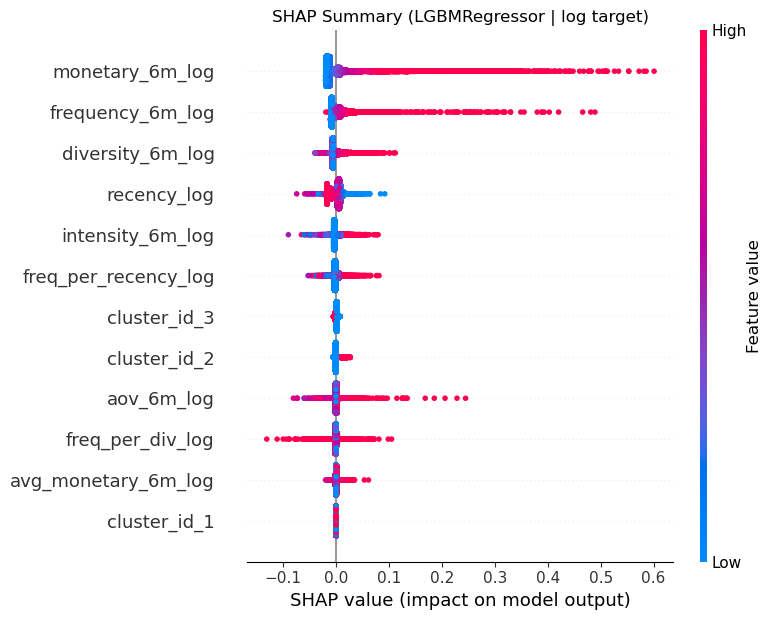

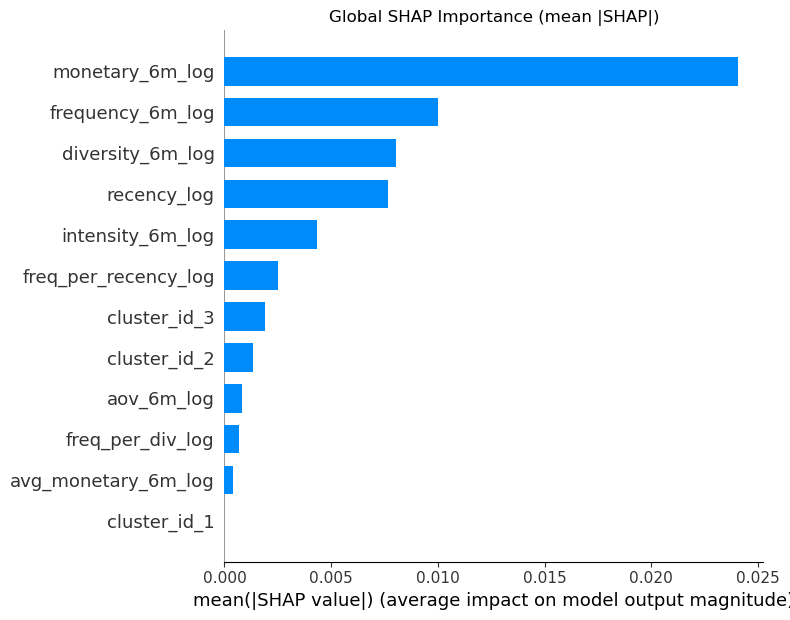

In [78]:
# SHAP

## 연산 효율을 위한 설정
SEED = 42
N_TRAIN = 200_000
N_SHAP  = 50_000

rng = np.random.RandomState(SEED)
idx_all = np.array(X_train.index)

## 랜덤 샘플링을 통해 효율적인 연산 환경 구축
idx_train = rng.choice(idx_all, size=min(N_TRAIN, len(idx_all)), replace=False)
idx_shap  = rng.choice(idx_train, size=min(N_SHAP, len(idx_train)), replace=False)

X_train_shap = X_train.loc[idx_train]
Y_train_shap = Y_train_log.loc[idx_train]
X_shap_raw = X_train.loc[idx_shap]

print("\n[SHAP] Train sample:", len(X_train_shap))
print("[SHAP] SHAP sample :", len(X_shap_raw))

## 전처리
### 전체 데이터셋을 기준으로 새로운 학습 기준을 세우기 위해 clone 사용 (독립적인 객체 구성)
prep_shap = clone(preprocess)
### fit_transform사용하여 오직 현재의 전체 데이터셋을 기준으로 전처리 기준점 구축 및 변환
Xtr_sh = prep_shap.fit_transform(X_train_shap, Y_train_shap)
Xsh = prep_shap.transform(X_shap_raw)

## 최적 반복 횟수의 평균을 사용하되, 연산 속도를 위해 범위를 제한
n_est = int(max(200, min(800, np.nanmean(best_iters) if len(best_iters) else 400)))

## 모델링
shap_model = LGBMRegressor(
    n_estimators=n_est,
    ### 학습률 (변수 영향력 파악)
    learning_rate=0.05,
    ### 복잡도 (너무 깊으면 특정 샘플에 과하게 반응)
    num_leaves=31,
    ### 샘플링 (일반화 성능 유지 및 속도 향상)
    subsample=0.8,
    colsample_bytree=0.8,
    ### 회귀 모드
    objective="regression",
    random_state=SEED,
    n_jobs=-1
)
## 샘플링된 전처리 데이터를 사용하여 해석용 모델 학습
shap_model.fit(Xtr_sh, Y_train_shap)

## 원-핫 인코딩 통해 생성된 피처를 포함하여, 전처리가 완료된 최종 컬럼명 리스트 추출
feature_names = prep_shap.get_feature_names_out()

## "__"를 기준으로 문자열을 잘라 마지막 부분만 남기기
clean_feature_names = [f.split("__")[-1] for f in feature_names]

## SHAP 시각화 호환성 위해, 원-핫으로 인한 Sparse를 Dense로 변환
Xsh_dense = Xsh.toarray() if hasattr(Xsh, "toarray") else np.asarray(Xsh)
### 피처 컬럼을 feature_names로 매핑
Xsh_df = pd.DataFrame(Xsh_dense, columns=clean_feature_names)

## TreeExplainer활용 SHAP 가치 산출
explainer = shap.TreeExplainer(shap_model)
### 피처가 이탈확률에 미친 영향 수치화
shap_values = explainer.shap_values(Xsh_dense)  # <- dense로 넣는 게 제일 안 터짐

## 시각화
### Summary plot : 피처 영향이 어느 방향인지
plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values, Xsh_df, show=False, max_display=20)
plt.title("SHAP Summary (LGBMRegressor | log target)")
plt.tight_layout()
plt.show()

### Bar importance : 변수의 방향성을 제외하고, 모델의 예측에 기여한 영향력의 크기 나열
plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values, Xsh_df, plot_type="bar", show=False, max_display=20)
plt.title("Global SHAP Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()

## 변수 제거

In [79]:
#변수 제거

df_cluster_future_spend_lgbm2 = df_cluster_future_spend_lgbm.copy()

## 타겟 변수 수치화 및 결측치, inf 처리
Y_raw = pd.to_numeric(df_cluster_future_spend_lgbm2[y_col], errors="coerce").replace([np.inf, -np.inf], np.nan)
idx_valid = Y_raw.dropna().index

## 결측치 없는 행 사용, 인덱스 0 부터 다시 부여
X_base = df_cluster_future_spend_lgbm2.loc[idx_valid, num_features_reg + cat_features].reset_index(drop=True)
## 실제 금액 타겟 생성
Y_raw_base = Y_raw.loc[idx_valid].reset_index(drop=True)
## 로그 변환 타겟 생성
Y_log_base = np.log1p(Y_raw_base)

## 데이터 무결성 확인
print("OOF base N:", len(X_base), len(Y_log_base), len(Y_raw_base))
assert len(X_base) == len(Y_log_base) == len(Y_raw_base)


OOF base N: 1286752 1286752 1286752


In [80]:
# 교차 검증 수행 (OOF)

## 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## 예측 값 저장소 생성
oof_pred_log_base = np.full(len(X_base), np.nan, dtype=float)

## 확률 산출 
for tr_idx, va_idx in kf.split(X_base):
    ### 훈련, 확인 데이터 분리
    X_tr, X_va = X_base.iloc[tr_idx], X_base.iloc[va_idx]
    Y_tr, Y_va = Y_log_base.iloc[tr_idx], Y_log_base.iloc[va_idx]

    ### clone을 통해 이전 폴드의 학습 기억 리셋 (누수 방지)
    prep = make_preprocess(num_features_reg)
    ### fit_transform사용하면 X_tr로만 학습
    Xtr = prep.fit_transform(X_tr, Y_tr)
    ### 위에서 학습한 기준을 확인 데이터에 적용 (스케일링)
    Xva = prep.transform(X_va)

    ### 모델 생성 및 학습 (조기 종료 적용)
    model = clone(base_lgbm)
    model.fit(
        Xtr, Y_tr,
        eval_set=[(Xva, Y_va)],
        #### 로그 스케일 오차 측정
        eval_metric="rmse",
        #### 50번 하고 개선 없으면 중단 (과적합 방지)
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    ### 확인 폴드 구간에 예측값 기록
    oof_pred_log_base[va_idx] = model.predict(Xva)

## 실제 금액으로 변환
oof_pred_base = np.expm1(oof_pred_log_base)
## 음수값 0으로 처리
oof_pred_base = np.clip(oof_pred_base, 0, None)

## 베이스라인 최종 지표 산출
rmse_base = rmse(Y_raw_base, oof_pred_base)
mae_base  = mae(Y_raw_base, oof_pred_base)

print("\n[BASELINE OOF | raw]")
## 큰 오차에 민감한 지표
print("RMSE:", rmse_base)
## 평균 오차 그액
print("MAE :", mae_base)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 13
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 13
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1965
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 13
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 13
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1961
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 13
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[BASELINE OOF | raw]
RMSE: 0.1573517959911951
MAE : 0.07403335805131496


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop          recency_log | ΔRMSE=+0.000238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop     frequency_6m_log | ΔRMSE=+0.000243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop      monetary_6m_log | ΔRMSE=-0.000010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1946
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1946
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop     diversity_6m_log | ΔRMSE=+0.000060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop           aov_6m_log | ΔRMSE=+0.000106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop     intensity_6m_log | ΔRMSE=+0.000104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop freq_per_recency_log | ΔRMSE=+0.000084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop     freq_per_div_log | ΔRMSE=-0.000010
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061079


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1029401, number of used features: 12
[LightGBM] [Info] Start training from score 0.061099


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1710
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.060933


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1705
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061095


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 1029402, number of used features: 12
[LightGBM] [Info] Start training from score 0.061074


/Users/handohyeon/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


drop  avg_monetary_6m_log | ΔRMSE=+0.000033


,dropped_feature,rmse,mae,delta_rmse,delta_mae,best_iter_mean
0,frequency_6m_log,0.157595,0.074095,0.000243,0.000061,150
1,recency_log,0.157589,0.074646,0.000238,0.000613,156
2,aov_6m_log,0.157458,0.074101,0.000106,0.000068,143
3,intensity_6m_log,0.157456,0.074107,0.000104,0.000074,143
4,freq_per_recency_log,0.157436,0.074092,0.000084,0.000059,146
5,diversity_6m_log,0.157412,0.074059,0.000060,0.000025,165
6,avg_monetary_6m_log,0.157385,0.074047,0.000033,0.000013,155
7,monetary_6m_log,0.157342,0.074007,-0.000010,-0.000027,183
8,freq_per_div_log,0.157342,0.074029,-0.000010,-0.000005,166


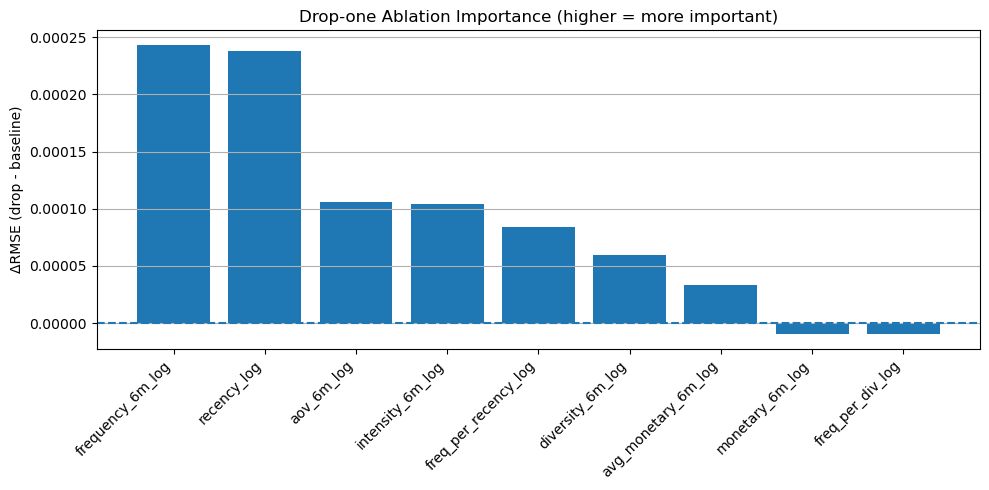

In [81]:
# OOF 기반 변수 기여도

rows = []

## 수치형 변수 하나씩 제외하고 학습 반복
for drop_feat in num_features_reg:
    ### 현재 변수를 제외한 나머지 변수 리스트 구성
    use_features = [f for f in num_features_reg if f != drop_feat]
    ### 제외된 피처 반영해서 데이터셋 구성 (길이 고정해서 비교의 공정성 유지)
    X_sub = X_base[use_features + cat_features]

    oof_pred_log = np.full(len(X_sub), np.nan, dtype=float)
    best_iters = []

    ## 교차 검증 시작
    for tr_idx, va_idx in kf.split(X_sub):
        ### 훈련, 확인 데이터 분리
        X_tr, X_va = X_sub.iloc[tr_idx], X_sub.iloc[va_idx]
        Y_tr, Y_va = Y_log_base.iloc[tr_idx], Y_log_base.iloc[va_idx]

        ### clone을 통해 이전 폴드의 학습 기억 리셋 (누수 방지)
        prep = make_preprocess(use_features)
        ### fit_transform사용하면 X_tr로만 학습
        Xtr = prep.fit_transform(X_tr, Y_tr)
        ### 위에서 학습한 기준을 확인 데이터에 적용 (스케일링)
        Xva = prep.transform(X_va)

        ### 모델 생성 및 학습 (조기 종료 적용)
        model = clone(base_lgbm)
        model.fit(
            Xtr, Y_tr,
            eval_set=[(Xva, Y_va)],
            #### 로그 스케일 오차 측정
            eval_metric="rmse",
            #### 50번 하고 개선 없으면 중단 (과적합 방지)
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        ### 예측값 기록 및 최적 학습 횟수 저장
        oof_pred_log[va_idx] = model.predict(Xva)
        best_iters.append(getattr(model, "best_iteration_", np.nan))

    ## 실제 금액으로 변환
    oof_pred = np.expm1(oof_pred_log)
    ## 음수값 0 처리
    oof_pred = np.clip(oof_pred, 0, None)

    ## 베이스라인 최종 지표 산출
    rmse_sub = rmse(Y_raw_base, oof_pred)
    mae_sub  = mae(Y_raw_base, oof_pred)

    ## 결과 저장
    rows.append({
        "dropped_feature": drop_feat,
        "rmse": rmse_sub,
        "mae": mae_sub,
        "delta_rmse": rmse_sub - rmse_base,
        "delta_mae": mae_sub - mae_base,
        "best_iter_mean": int(np.nanmean(best_iters)),
    })

    print(f"drop {drop_feat:>20s} | ΔRMSE={rmse_sub - rmse_base:+.6f}")


## 성능 변화 비교 위한 정렬 및 정리
ablation_df = (
    pd.DataFrame(rows)
    ### 내림차순 (위로 갈수록 필수 변수)
    .sort_values("delta_rmse", ascending=False)
    .reset_index(drop=True)
)
display(ablation_df)

## 시각화
plt.figure(figsize=(10, 5))
plt.bar(ablation_df["dropped_feature"], ablation_df["delta_rmse"])
plt.axhline(0, linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.ylabel("ΔRMSE (drop - baseline)")
plt.title("Drop-one Ablation Importance (higher = more important)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()



## TOP 30%

In [82]:
# Top 30% 성능 비교 (OOF 기준)

## 실제값 및 예측 값 정렬
### 실게 금액
Y_true = Y_raw_base.values
### OOF 예측값
Y_base = oof_pred_base
### 변수 제거 후 OOF 예측값
Y_pred = oof_pred                   


## 상위 30% 기준점 설정 (실제값 기준)
Top_30p = np.nanquantile(Y_true, 0.7)
mask_top = Y_true >= Top_30p

## RMSE (큰 오차에 민감)
rmse_base_top = np.sqrt(
    mean_squared_error(Y_true[mask_top], Y_base[mask_top])
)
rmse_model_top = np.sqrt(
    mean_squared_error(Y_true[mask_top], Y_pred[mask_top])
)

# MAE (직관적인 평균 금액 오차)
mae_base_top = mean_absolute_error(
    Y_true[mask_top], Y_base[mask_top]
)
mae_model_top = mean_absolute_error(
    Y_true[mask_top], Y_pred[mask_top]
)

print("Top 30% Baseline RMSE:", rmse_base_top)
print("Top 30% Model RMSE   :", rmse_model_top)
print("Top 30% RMSE 개선율  :", 1 - rmse_model_top / rmse_base_top)

print("Top 30% Baseline MAE :", mae_base_top)
print("Top 30% Model MAE    :", mae_model_top)
print("Top 30% MAE 개선율   :", 1 - mae_model_top / mae_base_top)

Top 30% Baseline RMSE: 0.2711504419614477
Top 30% Model RMSE   : 0.271230528216252
Top 30% RMSE 개선율  : -0.0002953572718706887
Top 30% Baseline MAE : 0.1548240996741919
Top 30% Model MAE    : 0.15483258923582355
Top 30% MAE 개선율   : -5.48335927643695e-05


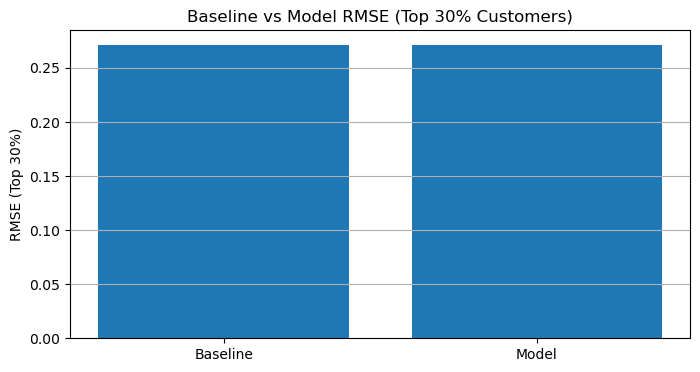

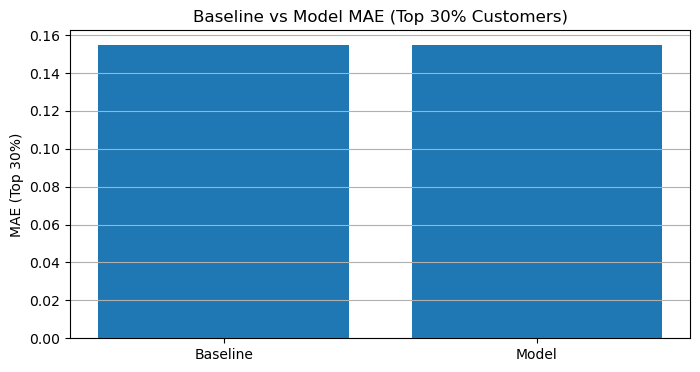

In [83]:
# Top_30% 성능 비교 시각화

labels = ["Baseline", "Model"]
rmse_vals = [rmse_base_top, rmse_model_top]
mae_vals  = [mae_base_top, mae_model_top]

plt.figure(figsize=(8,4))
plt.bar(labels, rmse_vals)
plt.ylabel("RMSE (Top 30%)")
plt.title("Baseline vs Model RMSE (Top 30% Customers)")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(labels, mae_vals)
plt.ylabel("MAE (Top 30%)")
plt.title("Baseline vs Model MAE (Top 30% Customers)")
plt.grid(axis="y")
plt.show()


In [84]:
# 학습 곡선 기록

## 학습 이력 저장소
eval_histories = []
## 최적 학습 횟수 저장소
best_iters = []

## K-Fold 진행 (데이터 누수 없이 전체 학습셋 활용)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), 1):
    ## 폴드별 데이터 분할
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = Y_train_log.iloc[tr_idx], Y_train_log.iloc[va_idx]

    ## 학습 데이터셋의 기준으로 독립된 전처리 수행 (누수 방지)
    prep = clone(preprocess)
    Xtr = prep.fit_transform(X_tr, y_tr) 
    Xva = prep.transform(X_va)

    ## 학습과 검증 오차를 동시에 추적하도록 설정 (모델 생성)
    model = clone(base_lgbm)
    model.fit(
        Xtr, y_tr,
        ### 두 세트를 모두 넣어 학습 곡선 비교 가능하게 함
        eval_set=[(Xtr, y_tr), (Xva, y_va)],
        eval_metric="rmse",
        eval_names=["train", "valid"],
        ### 50번하고 개선 없으면 중단 (과적합 방지)
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    ## 폴드별 결과 저장
    eval_histories.append(model.evals_result_)
    best_iters.append(model.best_iteration_)
    print(f"fold {fold} done | best_iter={model.best_iteration_}")

print("\nBest iters:", best_iters)
print("Median best_iter:", int(np.median(best_iters)))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 823520, number of used features: 12
[LightGBM] [Info] Start training from score 0.060949
fold 1 done | best_iter=129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1955
[LightGBM] [Info] Number of data points in the train set: 823521, number of used features: 12
[LightGBM] [Info] Start training from score 0.061036
fold 2 done | best_iter=144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006431 seconds.
You can set `force_row_wis

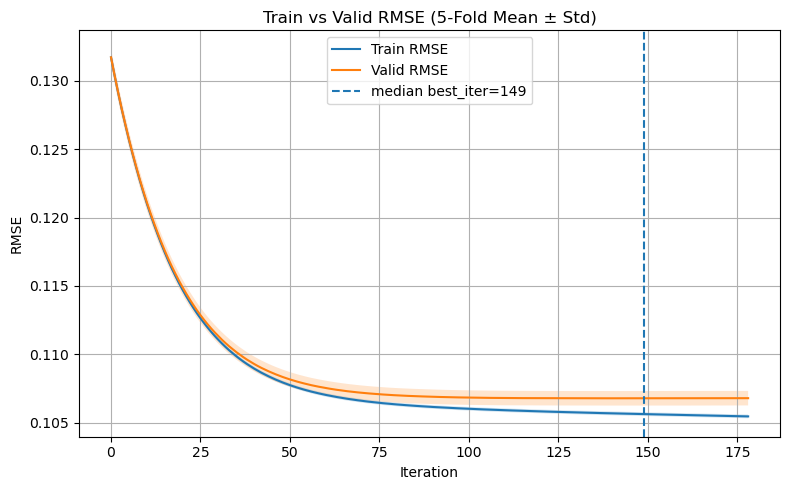

In [85]:
# Fold 평균 Train / Valid RMSE 학습 곡선 시각화

## 최소 학습 길이 산출
min_len = min(len(h["train"]["rmse"]) for h in eval_histories)

## 각 폴드별 RMSE 기록을 행렬로 변환하여 통계량 계산 준비
train_mat = np.array([h["train"]["rmse"][:min_len] for h in eval_histories])
valid_mat = np.array([h["valid"]["rmse"][:min_len] for h in eval_histories])

## 폴드 간의 평균 및 변동성 산출 (mean : 전반적인 학습 성능, std : 성능 변동성)
train_mean, train_std = train_mat.mean(axis=0), train_mat.std(axis=0)
valid_mean, valid_std = valid_mat.mean(axis=0), valid_mat.std(axis=0)

## 평균 학습 곡선 출력
plt.figure(figsize=(8, 5))
plt.plot(train_mean, label="Train RMSE")
plt.plot(valid_mean, label="Valid RMSE")

## 신뢰 구간 (오차 범위) 시각화 
plt.fill_between(range(min_len), train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(range(min_len), valid_mean-valid_std, valid_mean+valid_std, alpha=0.2)

## 최적 반복 횟수 표시 (중앙값)
best_med = int(np.median(best_iters))
if best_med < min_len:
    plt.axvline(best_med, linestyle="--", label=f"median best_iter={best_med}")

## 그래프 설정
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Train vs Valid RMSE (5-Fold Mean ± Std)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 절대 오차

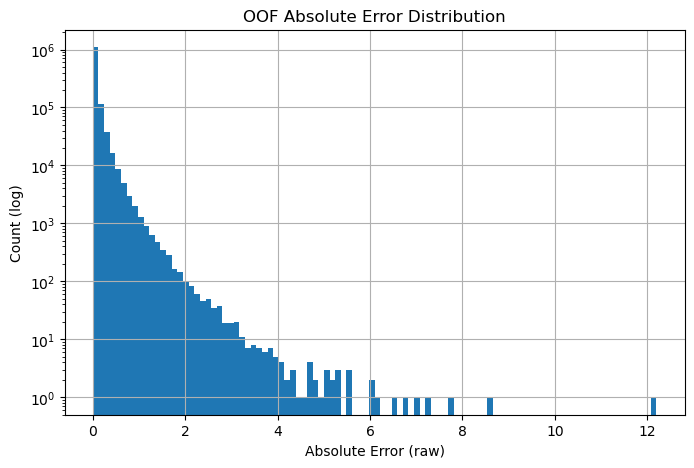

In [86]:
# OOF 절대 오차 분포 시각화

## 잔차 산출 (실제값 - 예측값)
oof_residual = Y_raw_base - oof_pred_base
## 절대 오차 계산 (방향 상관없이 크기만)
abs_error = np.abs(oof_residual)

## 시각화
plt.figure(figsize=(8,5))
### 빈도에 로그 적용
plt.hist(abs_error, bins=100, log=True)
plt.xlabel("Absolute Error (raw)")
plt.ylabel("Count (log)")
plt.title("OOF Absolute Error Distribution")
plt.grid(True)
plt.show()


### Expected Loss

In [87]:
# Expected Loss Score 산출 (이탈 가능성과 미래 가치를 결합)

## 기대 손실 계산 (이탈 확률 x 예측 매출액)
df_cluster_future_spend_lgbm2['expected_loss_score'] = (
    (df_cluster_future_spend_lgbm2['churn_proba_lgbm_isotonic']**0.3) * df_cluster_future_spend_lgbm2['pred_future_monetary_lgbm']
)

## Top-K 실제 손실액 검증 함수 (기본값 30%)
def topk_actual_loss(df, score_col, k=0.30):
    ### 점수와 실제 미래 매출만 추출
    d = df[[score_col, 'future_monetary_3m']].dropna().copy()
    ###  Expected Loss Score기준 내림차순
    d = d.sort_values(score_col, ascending=False)
    ### 상위 30%에 해당하는 고객 수 계산
    cutoff = int(len(d) * k)
    ### 관리가 시급한 상위 고객군 선택
    picked = d.iloc[:cutoff]
    
    return picked['future_monetary_3m'].sum(), picked.index

## k 지정
k = 0.30
## LGBM 모델 기반 우선순위 결과 산출
lgbm_sum, lgbm_idx = topk_actual_loss(df_cluster_future_spend_lgbm2,'expected_loss_score',k)

## 결과 출력
print(f"[Top {int(k*100)}% 실제 손실(미래매출) 합계]")
print(f"LGBM  : {lgbm_sum:,.0f}")

[Top 30% 실제 손실(미래매출) 합계]
LGBM  : 69,012


### Recall Curve

In [88]:
# Top-K Recall Curve


## 타겟팅 범위에 따른 재현율 변화 산출 함수
def topk_recall_curve(
    df,
    ### 기준 점수
    score_col,
    ### 실제 성과를 판가름할 타켓
    target_col="future_monetary_3m",
    k_list=None
):
    ### 타겟 비율 (k) 설정
    if k_list is None:
        k_list = np.linspace(0.1, 0.5, 5)

    ### 가독성 위해 반올림 
    k_list = np.round(k_list, 2)

    ### 타겟 이진화 (매출액을 구매 여부로 변환)
    y_true = (df[target_col] > 0).astype(int)
    ### 실제 구매 인원 산출
    total_positive = int(y_true.sum())
    assert total_positive > 0, "구매자가 없습니다."

    ### 데이터 정렬 및 인덱스 초기화 (점수 높은 순)
    df_sorted = (
        df.assign(y_true=y_true)
          .sort_values(score_col, ascending=False)
          .reset_index(drop=True)
    )

    ### k 지점 Recall 결과 저장소
    recalls = []
    n = len(df_sorted)
    
    ### 각 k 지점 Recall 계산
    for k in k_list:
        #### 상위 k% 해당 고객 수 산출
        top_n = max(1, int(round(n * float(k))))
        #### 상위 top_n중 실제로 구매한 인원 산출
        captured = int(df_sorted.iloc[:top_n]["y_true"].sum())
        #### Recall 계산 (추출 구매자 / 전체 구매자)
        recalls.append(captured / total_positive)

    return pd.DataFrame({"top_k_ratio": k_list, "recall": recalls})

## 함수 실행
recall_df = topk_recall_curve(
    df=df_cluster_future_spend_lgbm2,
    score_col="expected_loss_score",
    target_col="future_monetary_3m"
)

recall_df

,top_k_ratio,recall
0,0.1,0.225283
1,0.2,0.410664
2,0.3,0.564468
3,0.4,0.685699
4,0.5,0.781093


### Recall Curve 시각화

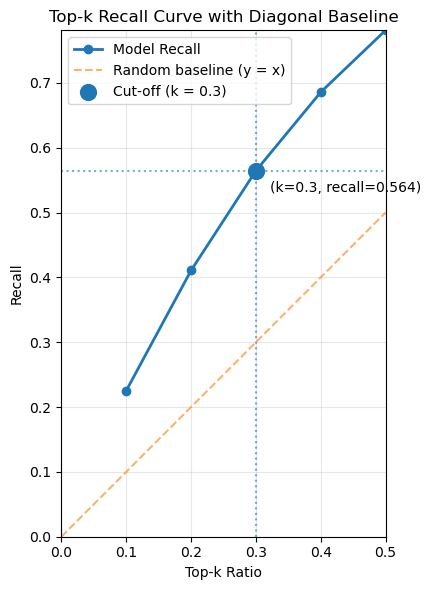

In [89]:
# Recall Curve 시각화

def plot_topk_recall_with_diagonal(recall_df, highlight_k=0.3):
    x = recall_df["top_k_ratio"].values
    y = recall_df["recall"].values

    ## 그래프 축 범위를 데이터 구간에 맞춤
    ### 현재 분석 범위
    xmax = x.max()    
    ### y값이 대각선보다 높아 y기준 설정
    ymax = max(y.max(), xmax)

    plt.figure(figsize=(7, 6))

    ## Recall curve 시각화
    plt.plot(x, y, marker="o", linewidth=2, label="Model Recall")

    ### 베이스라인 출력 (이 선보다 곡선이 높아야 향상도 높음)
    plt.plot([0, xmax], [0, xmax],
             linestyle="--", linewidth=1.5, alpha=0.6,
             label="Random baseline (y = x)")

    ### 특정 지점 강조
    if highlight_k in x:
        #### k지점 Recall 값 추출
        y_h = y[x.tolist().index(highlight_k)]
        
        plt.scatter(highlight_k, y_h, s=130, zorder=5, label=f"Cut-off (k = {highlight_k})")
        plt.axvline(highlight_k, linestyle=":", alpha=0.6)
        plt.axhline(y_h, linestyle=":", alpha=0.6)
        plt.annotate(f"(k={highlight_k}, recall={y_h:.3f})",
                     (highlight_k, y_h),
                     xytext=(10, -15), textcoords="offset points", fontsize=10)

    ### 시각적 정밀도 설정
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    # (선택) 대각선이 진짜 45도로 보이게
    plt.gca().set_aspect("equal", adjustable="box")

    plt.xlabel("Top-k Ratio")
    plt.ylabel("Recall")
    plt.title("Top-k Recall Curve with Diagonal Baseline")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## 30% 시각화
plot_topk_recall_with_diagonal(recall_df, highlight_k=0.3)

### 상위 30% 우선 관리 대상자 확정

In [90]:
# 상위 30% 우선 관리 대상자 확정

## 전체 고객 수의 30% 행 수 구하기
cutoff = int(len(df_cluster_future_spend_lgbm2) * 0.3)

## 고위험/고가치 고객 선별
df_top30_expected_loss = (
    df_cluster_future_spend_lgbm2
    .sort_values('expected_loss_score', ascending=False)
    .head(cutoff)
    .copy()
)

In [91]:
# 상위 30% 타겟팅 재현율 검증

## Recall = TOP30 실제 타겟 수 / 전체 타겟 수
total_target = (df_cluster_future_spend_lgbm2['future_monetary_3m'] > 0).sum()
captured_target = (df_top30_expected_loss['future_monetary_3m'] > 0).sum()
recall_top30 = captured_target / total_target

recall_top30


np.float64(0.5644658412562902)

In [92]:
# 상위 30% 타켓팅 정밀도 검증

## 정밀도 지표 산출
precision_top30 = (
    ### 실제로 구매가 일어난 경우
    (df_top30_expected_loss['future_monetary_3m'] > 0).mean()
)
precision_top30

np.float64(0.6645657664659025)

In [93]:
# 모델의 비즈니스 기여도 측정 (향상도)

## 전체 매출 발생률 (모델의 도움 없이 전체 고객에게 무작위로 마케팅을 했을 때 기대할 수 있는 구매 전환율)
base_rate = (df_cluster_future_spend_lgbm2['future_monetary_3m'] > 0).mean()

## 향상도 계산
uplift_precision = precision_top30 / base_rate

print("Base rate:", base_rate)
print("Precision @30%:", precision_top30)
print("Uplift:", uplift_precision)


Base rate: 0.3532001504563428
Precision @30%: 0.6645657664659025
Uplift: 1.881555728691701


In [94]:
# 상위 30% 타겟 그룹이 의도한 대로 정확한 규모로 추출되었는지 확인

## 우선 관리대상, 전체 분석 대상 고객 중 추출된 타겟 그룹이 차지하는 정확한 비율
len(df_top30_expected_loss), len(df_top30_expected_loss) / len(df_cluster_future_spend_lgbm2)

(386025, 0.2999995337096814)

In [95]:
# 최종 파일 생성

## 분석 및 전략 수립을 위한 핵심 컬럼 정의
final_cols = [
    'customer_id',               
    'cluster_id',                

    'recency',                   # 마지막 구매 후 경과일
    'frequency_6m',              # 최근 6개월 구매 횟수
    'monetary_6m',               # 최근 6개월 총 구매 금액
    'diversity_6m',              # 구매 상품 카테고리의 다양성
    'focus_6m',                  # 특정 카테고리 집중도
    'aov_6m',                    # 평균 주문 금액
    'intensity_6m',              # 구매 강도
    'freq_per_recency',          # 활동 기간 대비 구매 빈도
    'avg_monetary_6m',           # 1회 평균 결제액

    'churn_proba_lgbm_isotonic', # 이탈 확률
    'pred_future_monetary_lgbm', # 향후 3개월 예상 매출액 (회귀 모델 결과)

    # [전략 우선순위 점수]
    'expected_loss_score'        # 최종 방어 우선순위
]

## 상위 30% 데이터프레임에서 핵심 컬럼만 추출 및 복제
Top_30p_result = df_top30_expected_loss[final_cols].copy()

#결과 확인
Top_30p_result.head()

,customer_id,cluster_id,recency,frequency_6m,monetary_6m,diversity_6m,focus_6m,aov_6m,intensity_6m,freq_per_recency,avg_monetary_6m,churn_proba_lgbm_isotonic,pred_future_monetary_lgbm,expected_loss_score
19069,03d0011487606c37c1b1ed147fc72f285a50c05f00b971...,2,1,366.0,15.381254,9.0,0.024523,0.041911,7.690627,183.000000,0.041911,0.009732,11.642459,2.900749
803717,9ff538b9a79943aff0eeb492da5330595a57f696099a40...,2,1,156.0,6.649186,7.0,0.044586,0.042352,3.324593,78.000000,0.042352,0.021903,5.650374,1.795672
1239596,f69cf6fca69045a8259f9554e318e00fbf5e8e758e88b1...,2,2,160.0,9.585559,6.0,0.037267,0.059538,3.195186,53.333333,0.059538,0.021692,5.327683,1.688216
452505,5a1cf6cc59d94c0cd039b27524c8f5e42a9e0e0fe240fc...,2,6,267.0,9.925390,7.0,0.026119,0.037035,1.417913,38.142857,0.037035,0.021692,4.836749,1.532651
1038810,ceb037bfdab35cdd507685b20648829ddc0d92c8e02e2f...,2,8,190.0,7.899864,7.0,0.036649,0.041361,0.877763,21.111111,0.041361,0.021903,4.648492,1.477277


In [ ]:
# 결과 파일 생성

# Top_30p_result.to_csv('Top_3p_result.csv',index=False)

In [97]:
# 상위 30% 고객의 군집별 분포 분석

cluster_top30_dist = (
    Top_30p_result
    .groupby('cluster_id')
    .size()
    .reset_index(name='top30_customers')
)
cluster_top30_dist

,cluster_id,top30_customers
0,0,197515
1,1,7
2,2,49862
3,3,138641
